In [4]:
import random

import numpy as np
from enum import Enum

Methods = Enum('Methods', ['Classic', 'Momentum', 'AdaGrad', 'RMSprop', 'Adam', 'Nesterov'])
Regularization = Enum('Regularization', ['WithoutRegularization', 'L1', 'L2', 'Elastic'])
LearningRate = Enum('LearningRate', ['Const', 'Dichotomy'])
LearningRateScheduling = Enum('LearningRateScheduling', ['Classic', 'Stepwise', 'Exponential'])


def sign(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return -1


class LinearRegression:
    def __init__(self, T, W, X, Y, regularization=Regularization.WithoutRegularization, l1=0.1, l2=0.1):
        self.T = np.array([T[i % len(T)](X[i // len(T)]) for i in range(len(T) * len(X))]).reshape(len(X), len(T))
        self.W = W
        self.X = X
        self.Y = Y
        self.regularization = regularization
        self.l1 = l1
        self.l2 = l2

    def loss(self, W_Arg):
        val = sum([(np.dot(self.T[i], W_Arg) - self.Y[i]) ** 2 for i in range(len(self.X))])
        match self.regularization:
            case Regularization.L1:
                val += self.l1 * sum([abs(w) for w in self.W]) / len(self.W)
            case Regularization.L2:
                val += self.l2 * sum([w ** 2 for w in self.W]) / len(self.W)
            case Regularization.Elastic:
                val += (self.l1 * sum([abs(w) for w in self.W])) / len(self.W) + (
                        self.l2 * sum([w ** 2 for w in self.W])) / len(self.W)
        return val

    def grad_by_components(self, index_components, W_Arg):
        grad_with_batch = np.zeros(len(W_Arg))
        for i in index_components:
            grad_with_batch += 2 * (np.dot(self.T[i], W_Arg) - self.Y[i]) * self.T[i]
        match self.regularization:
            case Regularization.L1:
                grad_with_batch += self.l1 * np.array([sign(w) for w in self.W]) / len(self.W)
            case Regularization.L2:
                grad_with_batch += self.l2 * 2 * self.W / len(self.W)
            case Regularization.Elastic:
                grad_with_batch += (self.l1 * np.array([sign(w) for w in self.W])) / len(self.W) + (
                        self.l2 * 2 * self.W) / len(self.W)

        return grad_with_batch


def sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, beta_1, beta_2, eps_adam, is_corr_beta_1=True,
        is_corr_beta_2=True, is_nesterov=False, decay=0.95):
    i = 0
    prev_W = lin_reg.loss(lin_reg.W)
    V = np.zeros(len(lin_reg.W))
    S = np.zeros(len(lin_reg.W))
    lrs_func = lrs_handler(lrs, decay)

    while True:
        i += 1

        components = [(i * batch + j) % len(lin_reg.X) for j in range(batch)]
        cur_w = lin_reg.W
        grad_with_batch = lin_reg.grad_by_components(components, cur_w)

        alpha = lrs_func(lr(lambda a: lin_reg.loss(lin_reg.W - a * grad_with_batch)), (i * batch) % len(lin_reg.X))
        if is_nesterov:
            cur_w -= alpha * beta_1 * V
            grad_with_batch = lin_reg.grad_by_components(components, cur_w)

        V = (beta_1 * V) + (1 - beta_1) * grad_with_batch
        S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2)
        if is_corr_beta_1:
            V /= 1 - (beta_1 ** (i + 1))
        if is_corr_beta_2:
            S /= 1 - (beta_2 ** (i + 1))

        lin_reg.W -= alpha * (V / ((S + eps_adam) ** 0.5))
        if abs(lin_reg.loss(lin_reg.W) - prev_W) < eps or i >= max_num_of_step:
            break
        prev_W = lin_reg.loss(lin_reg.W)

    return i


def sgd_handler(lin_reg, lr, method, lrs=LearningRateScheduling.Classic, batch=1, beta_1=0.9, beta_2=0.999,
                eps_adam=10 ** -8,
                eps=0.001, max_num_of_step=10000):
    match method:
        case Methods.Classic:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, 0, 1, 1, False, False)
        case Methods.Momentum:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, beta_1, 1, 1, False, False)
        case Methods.AdaGrad:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, 0, 0, eps_adam, False, False)
        case Methods.RMSprop:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, 0, beta_2, eps_adam, False)
        case Methods.Adam:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, beta_1, beta_2, eps_adam)
        case Methods.Nesterov:
            return sgd(lin_reg, lr, lrs, eps, batch, max_num_of_step, beta_1, 1, 1, False, False, True)


def lr_dichotomy(eps, delt):
    return lambda lin_reg: dichotomy(lin_reg, 0, right_border_calc(lin_reg), eps, delt)


def right_border_calc(func):
    right_start = 0.0000001
    zero = func(0.)
    while zero >= func(right_start):
        right_start *= 1.3

    return right_start


def dichotomy(func, a_1, a_2, eps, delt):
    while abs(a_1 - a_2) >= eps:
        new_a_1 = (a_1 + a_2) / 2 - delt
        new_a_2 = (a_1 + a_2) / 2 + delt
        fv1 = func(new_a_1)
        fv2 = func(new_a_2)
        if fv2 > fv1:
            a_2 = new_a_2
        elif fv2 < fv1:
            a_1 = new_a_1
        else:
            a_1 = new_a_1
            a_2 = new_a_2
    return (a_1 + a_2) / 2


def lrs_exp(decay=0.99):
    return lambda lr, t: lr * (decay ** t)


def lrs_step(decay=0.99):
    return lambda lr, t: lr / (1 + decay * t)


def lrs_handler(lrs, decay=0.99):
    match lrs:
        case LearningRateScheduling.Classic:
            return lambda lr, t: lr
        case LearningRateScheduling.Stepwise:
            return lrs_step(decay)
        case LearningRateScheduling.Exponential:
            return lrs_exp(decay)



In [5]:
import matplotlib.pyplot as plt


def visualise_points(linear_reg):
    x = np.linspace(-10, 10, 1000)
    y = linear_reg.W[0] * x + linear_reg.W[1]
    plt.plot(x, y, '-r')
    plt.plot(linear_reg.X, linear_reg.Y, 'og', linestyle='None')
    plt.xlabel("x")
    plt.show()
    print(linear_reg.W)
    print(linear_reg.loss(linear_reg.W))


C:\Users\vryab\AppData\Local\Temp\ipykernel_19060\4186473926.py:32: RuntimeWarning: overflow encountered in scalar add
  val = sum([(np.dot(self.T[i], W_Arg) - self.Y[i]) ** 2 for i in range(len(self.X))])
C:\Users\vryab\AppData\Local\Temp\ipykernel_19060\4186473926.py:80: RuntimeWarning: overflow encountered in square
  S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2)
C:\Users\vryab\AppData\Local\Temp\ipykernel_19060\4186473926.py:80: RuntimeWarning: invalid value encountered in multiply
  S = (beta_2 * S) + (1 - beta_2) * (grad_with_batch ** 2)


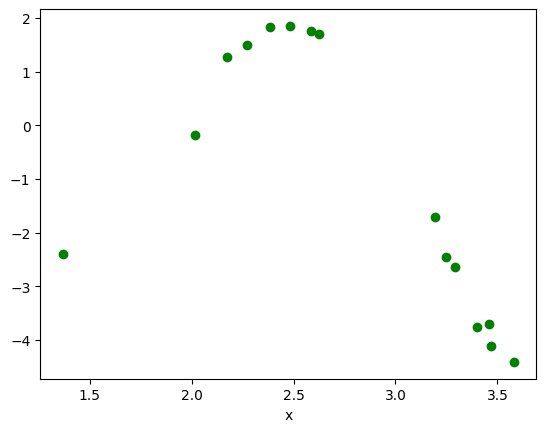

[nan nan nan nan nan nan]
nan


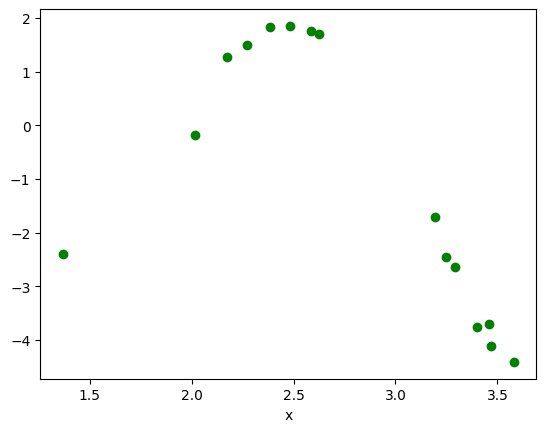

[nan nan nan nan nan nan]
nan


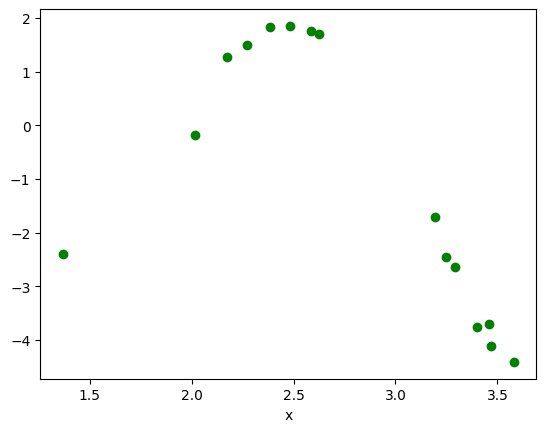

[nan nan nan nan nan nan]
nan


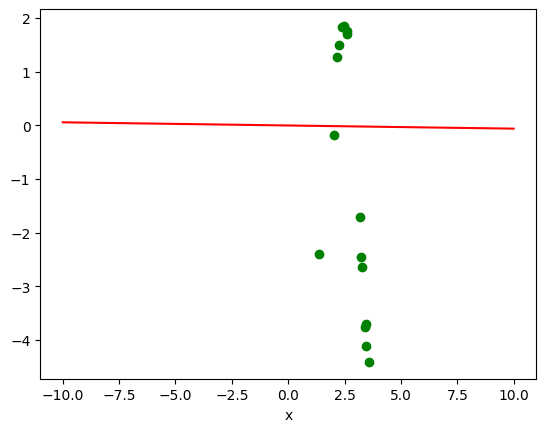

[-5.90554423e-03 -1.77568734e-03 -5.29412663e-04 -1.55830474e-04
 -4.50068406e-05 -1.26552909e-05]
38.65792260378933


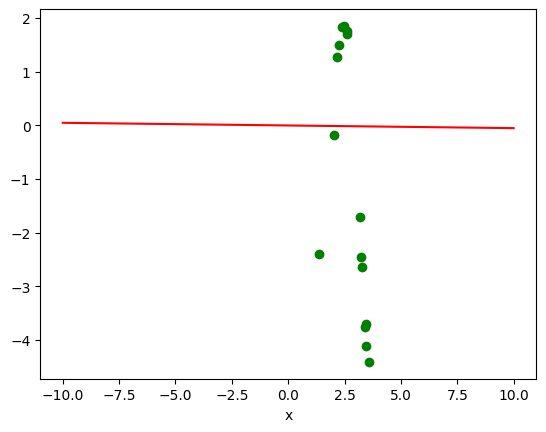

[-4.97586890e-03 -1.49796517e-03 -4.51347429e-04 -1.36089078e-04
 -4.10524610e-05 -1.23856831e-05]
40.400472698332464


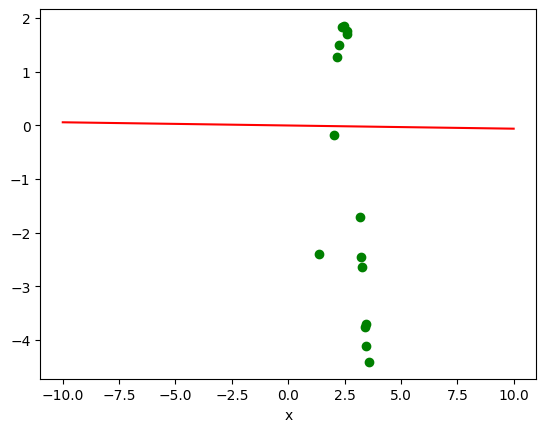

[-5.95340499e-03 -1.82102946e-03 -5.54917741e-04 -1.68161356e-04
 -5.05396369e-05 -1.50004292e-05]
38.66505607623558


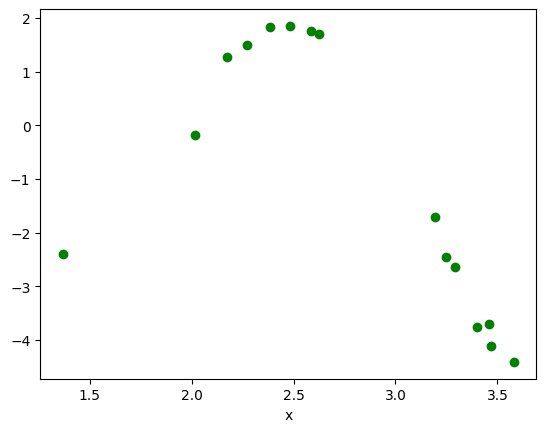

[nan nan nan nan nan nan]
nan


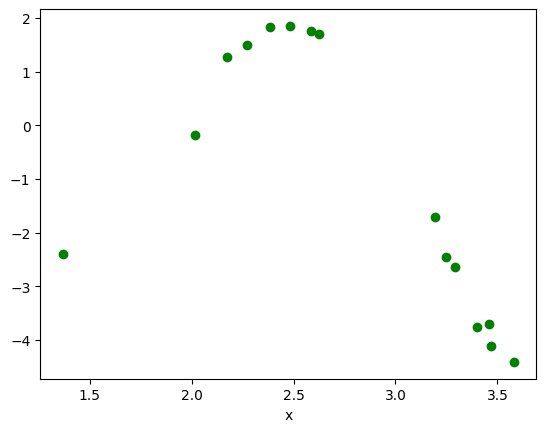

[nan nan nan nan nan nan]
nan


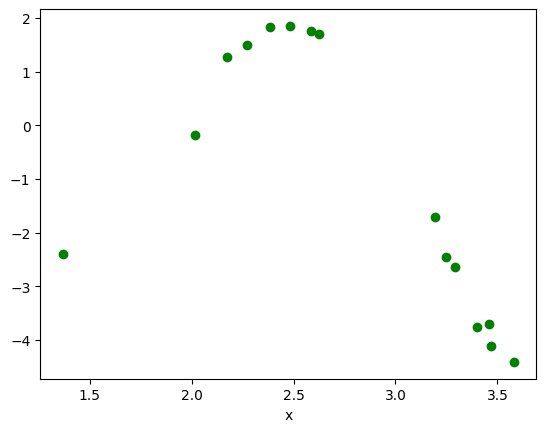

[nan nan nan nan nan nan]
nan


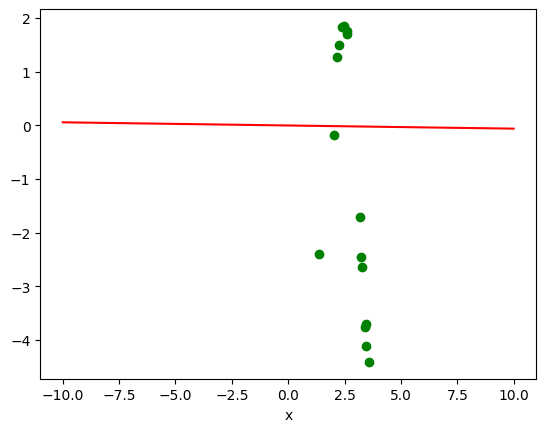

[-5.90554423e-03 -1.77568734e-03 -5.29412663e-04 -1.55830474e-04
 -4.50068406e-05 -1.26552909e-05]
38.65792260378933


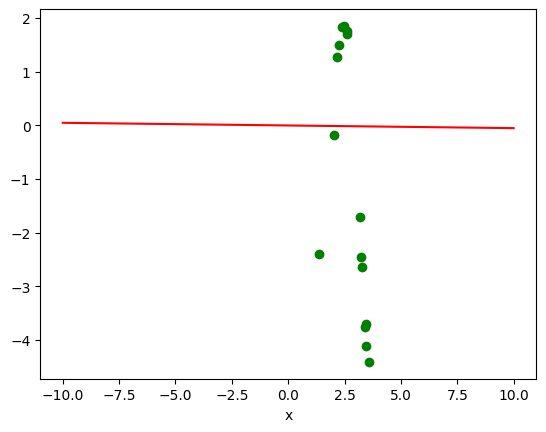

[-4.97586890e-03 -1.49796517e-03 -4.51347429e-04 -1.36089078e-04
 -4.10524610e-05 -1.23856831e-05]
40.400472698332464


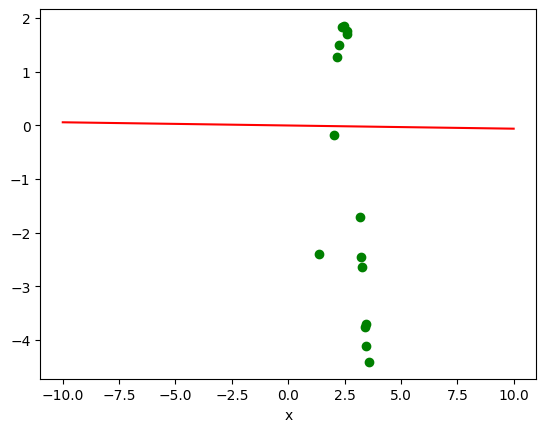

[-5.95340499e-03 -1.82102946e-03 -5.54917741e-04 -1.68161356e-04
 -5.05396369e-05 -1.50004292e-05]
38.66505607623558


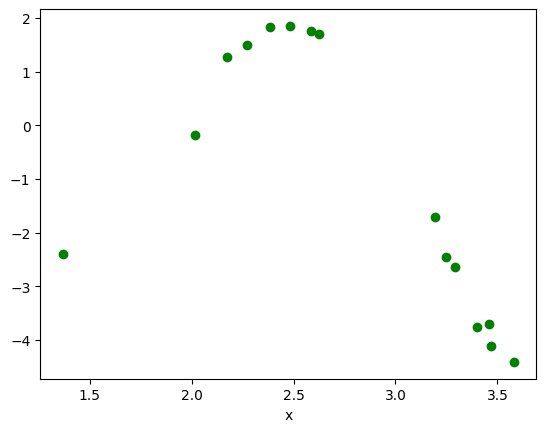

[nan nan nan nan nan nan]
nan


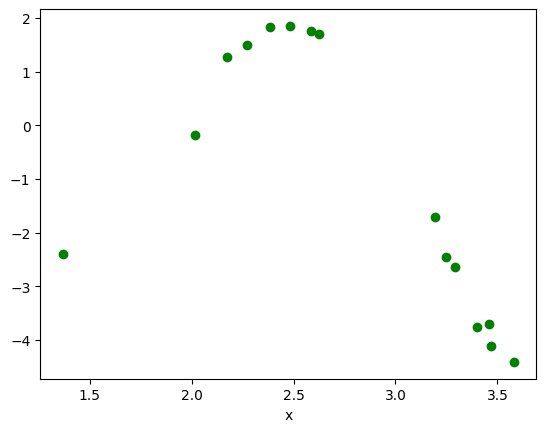

[nan nan nan nan nan nan]
nan


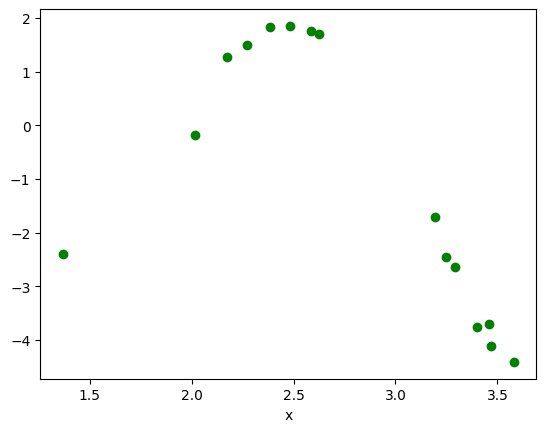

[nan nan nan nan nan nan]
nan


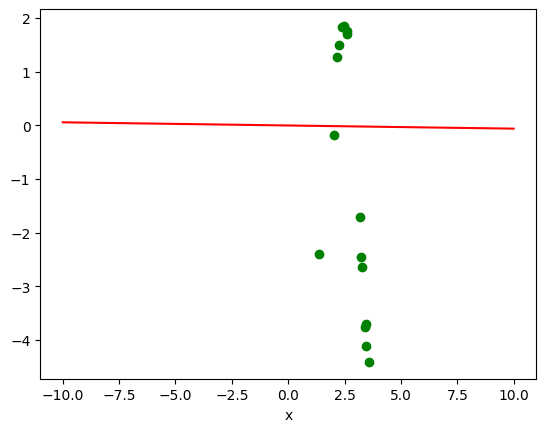

[-5.90554423e-03 -1.77568734e-03 -5.29412663e-04 -1.55830474e-04
 -4.50068406e-05 -1.26552909e-05]
38.65792260378933


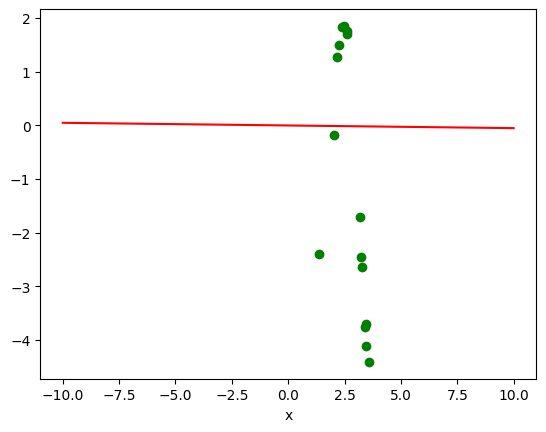

[-4.97586890e-03 -1.49796517e-03 -4.51347429e-04 -1.36089078e-04
 -4.10524610e-05 -1.23856831e-05]
40.400472698332464


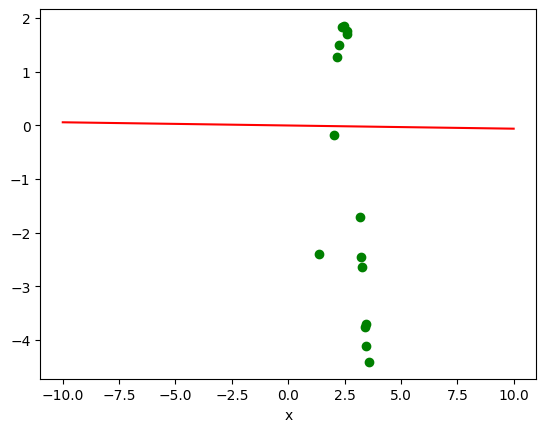

[-5.95340499e-03 -1.82102946e-03 -5.54917741e-04 -1.68161356e-04
 -5.05396369e-05 -1.50004292e-05]
38.66505607623558


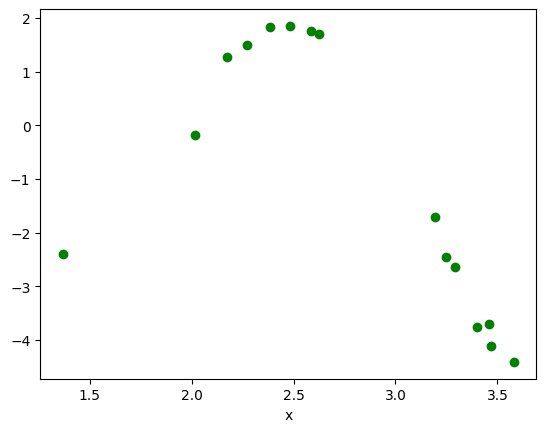

[nan nan nan nan nan nan]
nan


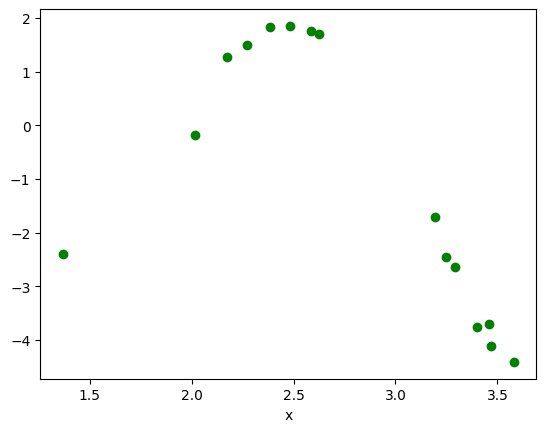

[nan nan nan nan nan nan]
nan


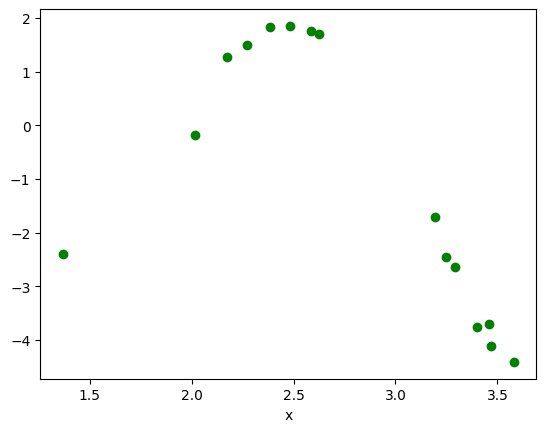

[nan nan nan nan nan nan]
nan


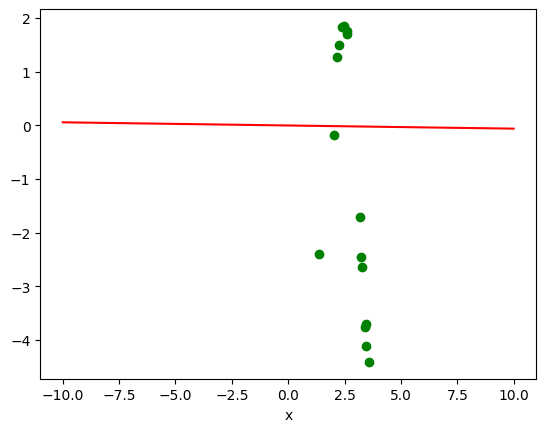

[-5.90554423e-03 -1.77568734e-03 -5.29412663e-04 -1.55830474e-04
 -4.50068406e-05 -1.26552909e-05]
38.65792260378933


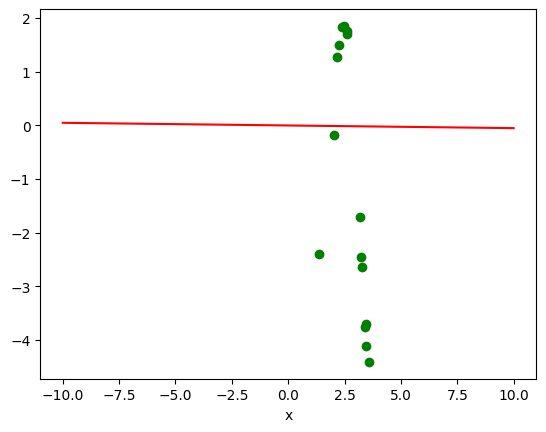

[-4.97586890e-03 -1.49796517e-03 -4.51347429e-04 -1.36089078e-04
 -4.10524610e-05 -1.23856831e-05]
40.400472698332464


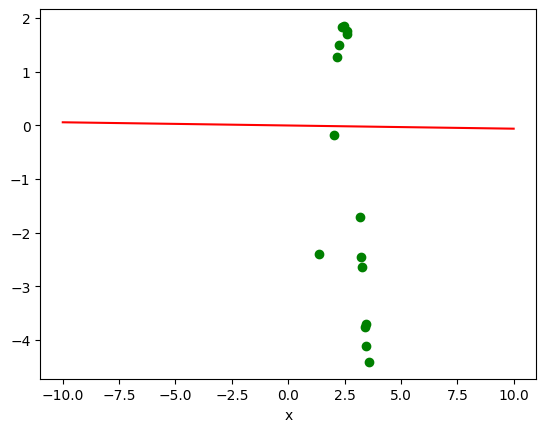

[-5.95340499e-03 -1.82102946e-03 -5.54917741e-04 -1.68161356e-04
 -5.05396369e-05 -1.50004292e-05]
38.66505607623558


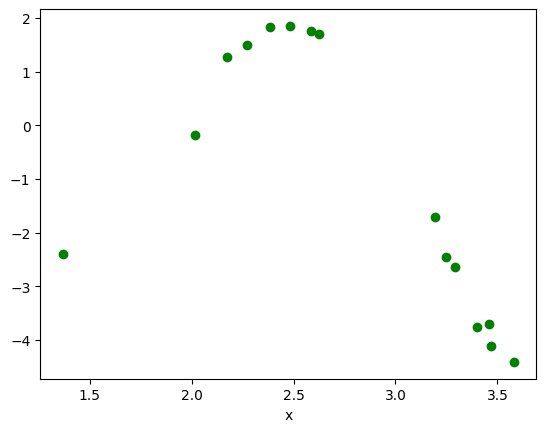

[nan nan nan nan nan nan]
nan


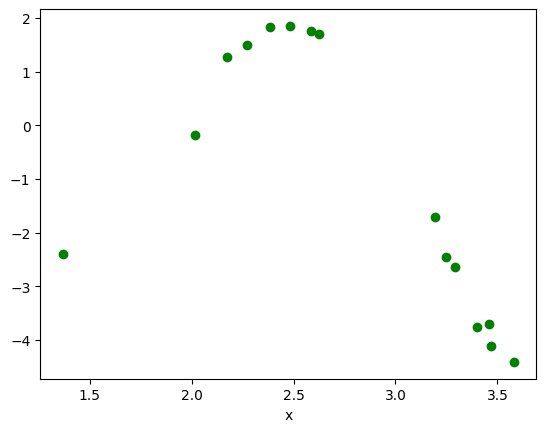

[nan nan nan nan nan nan]
nan


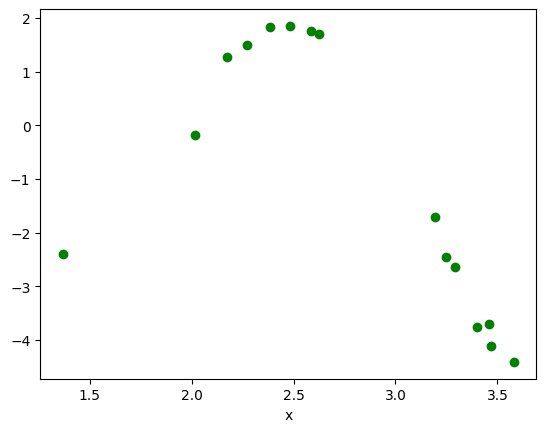

[nan nan nan nan nan nan]
nan


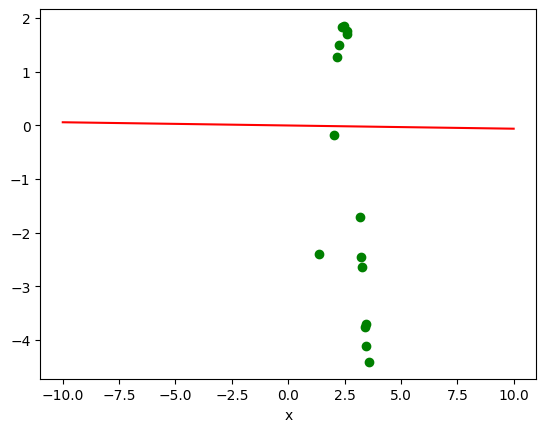

[-5.99419768e-03 -1.74880374e-03 -5.07234871e-04 -1.45627648e-04
 -4.10871605e-05 -1.12493039e-05]
38.63218619539427


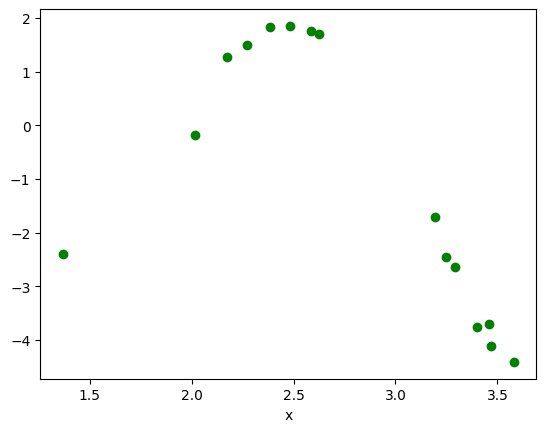

[nan nan nan nan nan nan]
nan


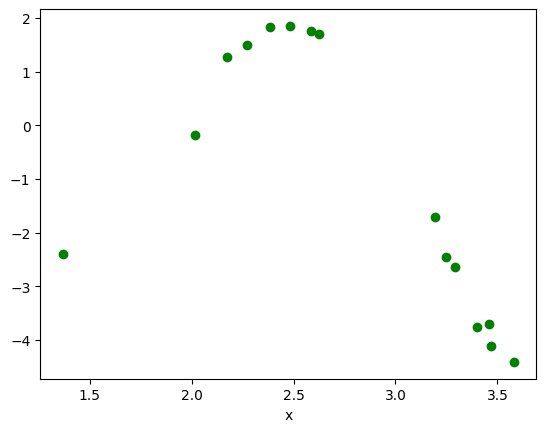

[nan nan nan nan nan nan]
nan


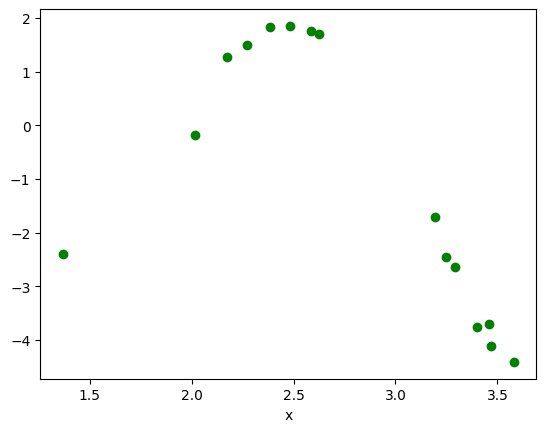

[nan nan nan nan nan nan]
nan


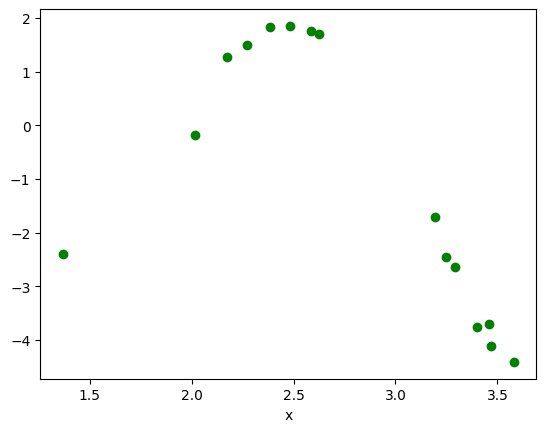

[nan nan nan nan nan nan]
nan


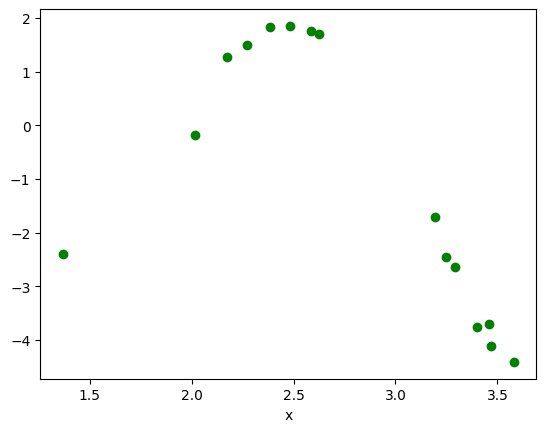

[nan nan nan nan nan nan]
nan


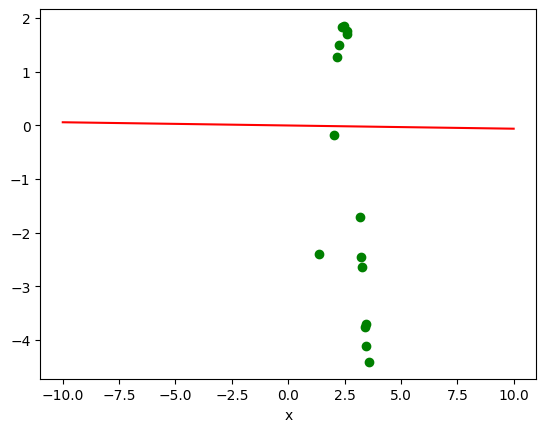

[-5.99419768e-03 -1.74880374e-03 -5.07234871e-04 -1.45627648e-04
 -4.10871605e-05 -1.12493039e-05]
38.63218619539427


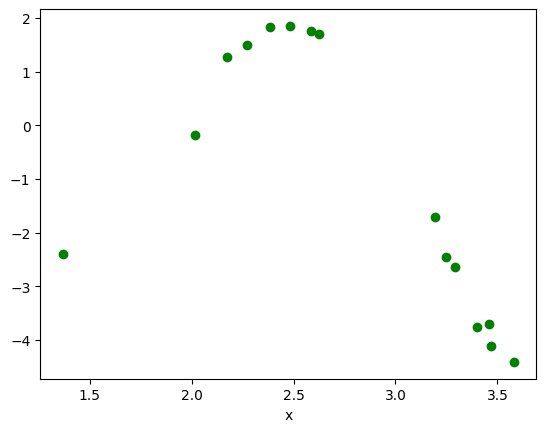

[nan nan nan nan nan nan]
nan


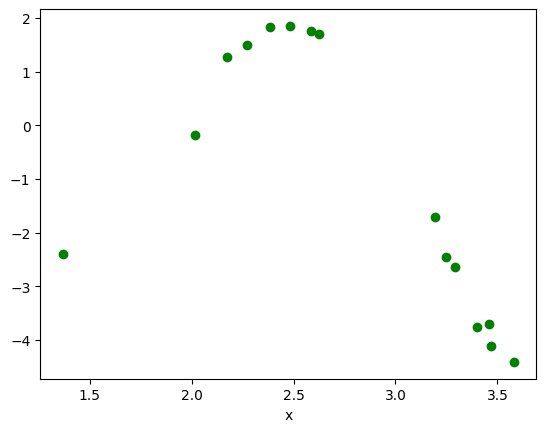

[nan nan nan nan nan nan]
nan


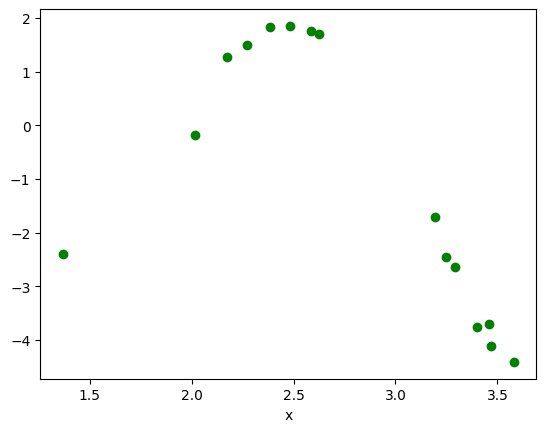

[nan nan nan nan nan nan]
nan


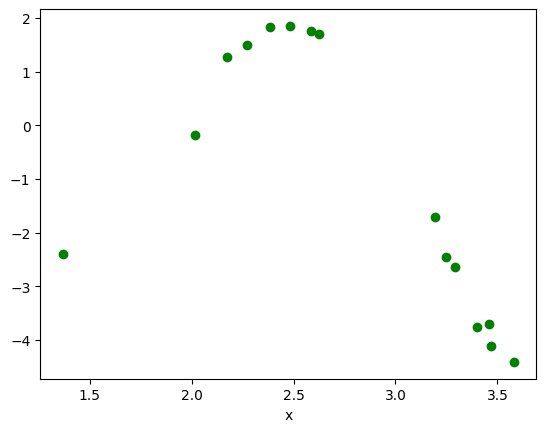

[nan nan nan nan nan nan]
nan


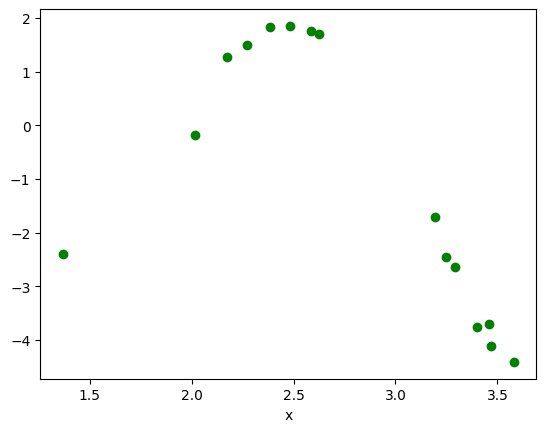

[nan nan nan nan nan nan]
nan


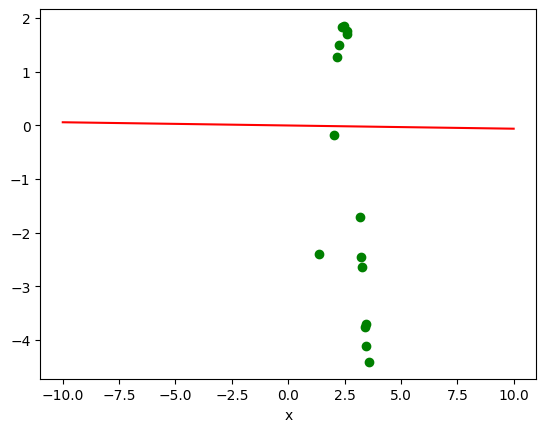

[-5.99419768e-03 -1.74880374e-03 -5.07234871e-04 -1.45627648e-04
 -4.10871605e-05 -1.12493039e-05]
38.63218619539427


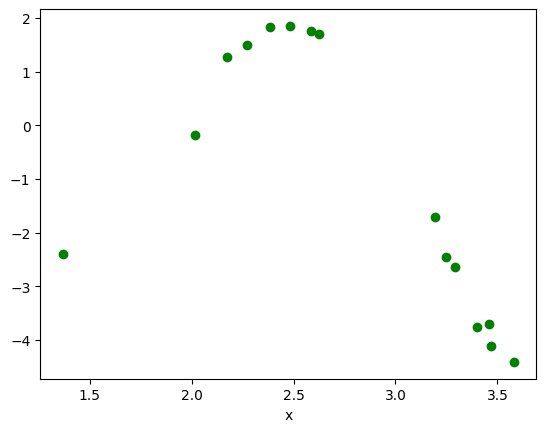

[nan nan nan nan nan nan]
nan


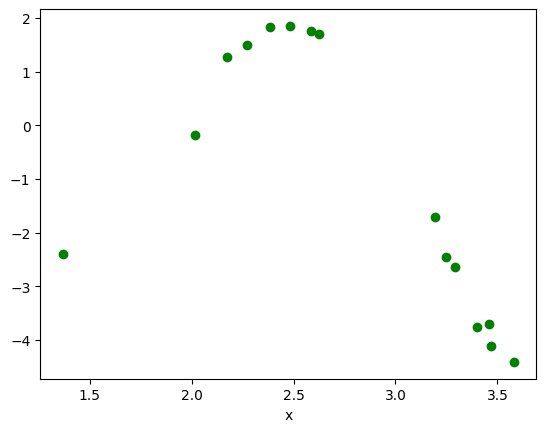

[nan nan nan nan nan nan]
nan


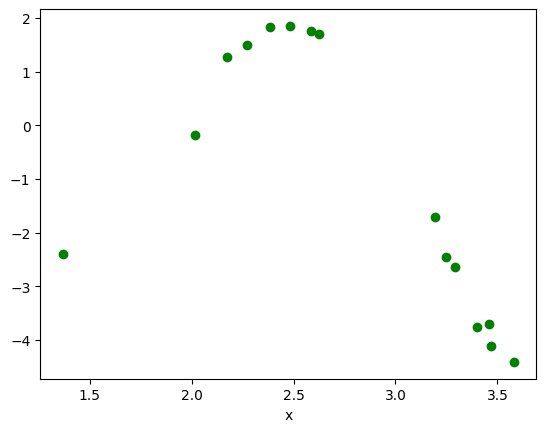

[nan nan nan nan nan nan]
nan


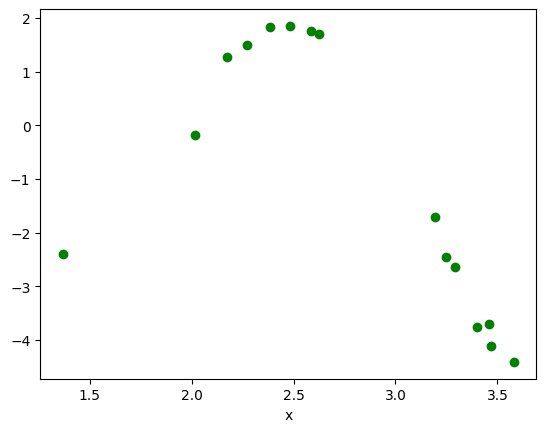

[nan nan nan nan nan nan]
nan


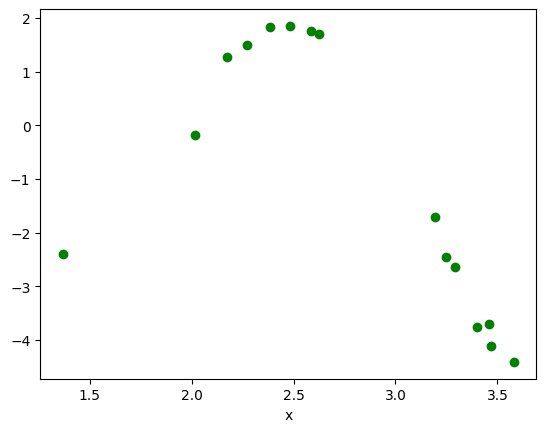

[nan nan nan nan nan nan]
nan


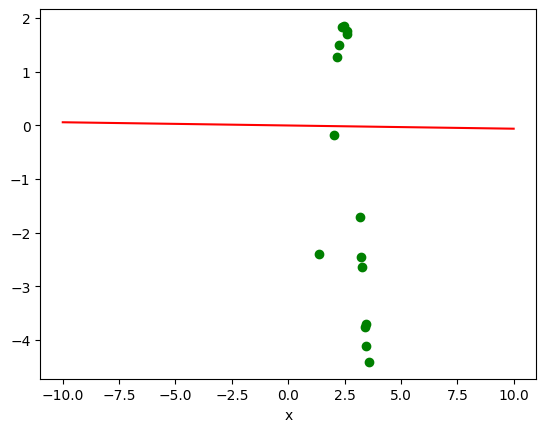

[-5.99419768e-03 -1.74880374e-03 -5.07234871e-04 -1.45627648e-04
 -4.10871605e-05 -1.12493039e-05]
38.63218619539427


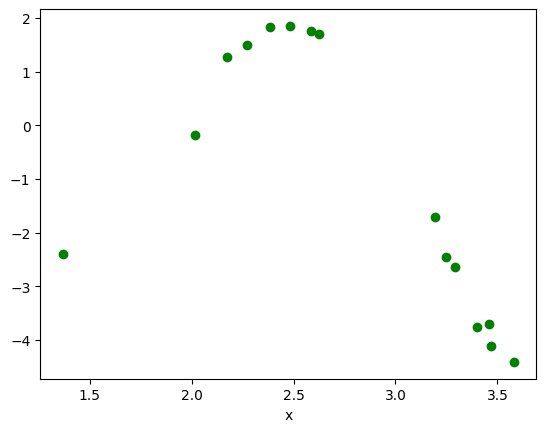

[nan nan nan nan nan nan]
nan


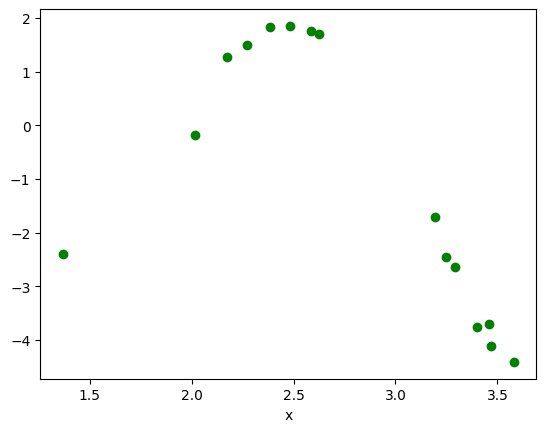

[nan nan nan nan nan nan]
nan


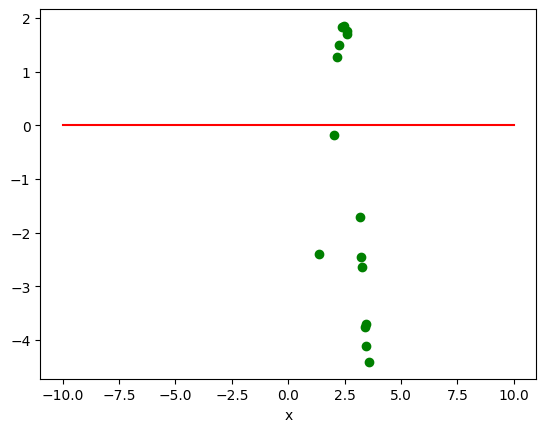

[1.56269043e-10 4.99174159e-10 1.76791407e-09 6.73046313e-09
 2.71403558e-08 1.16486648e-07]
102.58318569284761


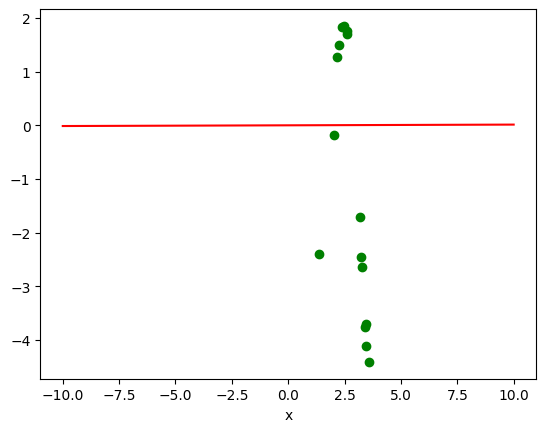

[0.00133417 0.00133432 0.00133503 0.00133838 0.00135415 0.00142773]
144.36486269907314


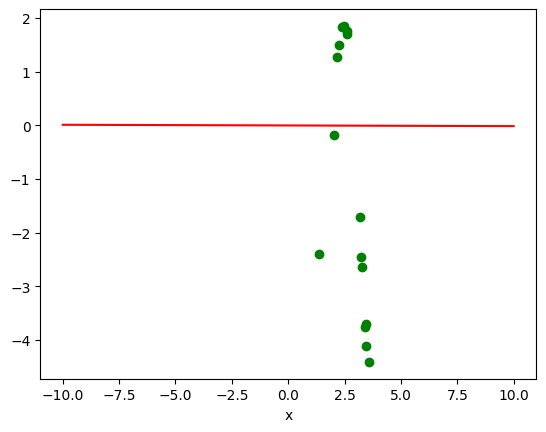

[-0.00127375 -0.00127151 -0.0012561  -0.00115187 -0.00051582  0.00189073]
72.90396437411165


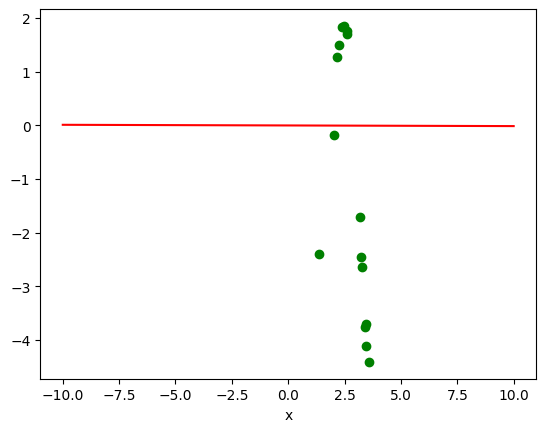

[-0.00121437 -0.00121437 -0.00121437 -0.00121437 -0.00121437 -0.00121437]
73.90763762551956


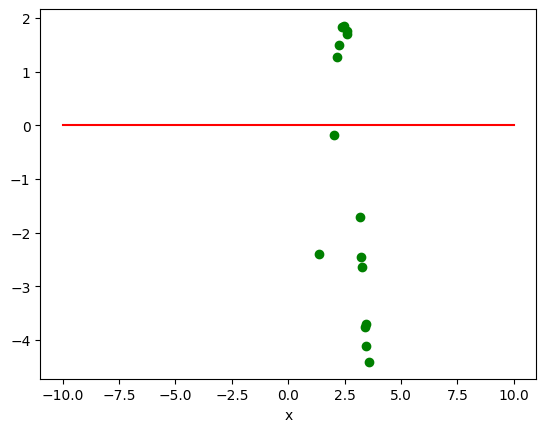

[2.56410256e-08 2.56410256e-08 2.56410256e-08 2.56410256e-08
 2.56410256e-08 2.56410256e-08]
102.5838670464333


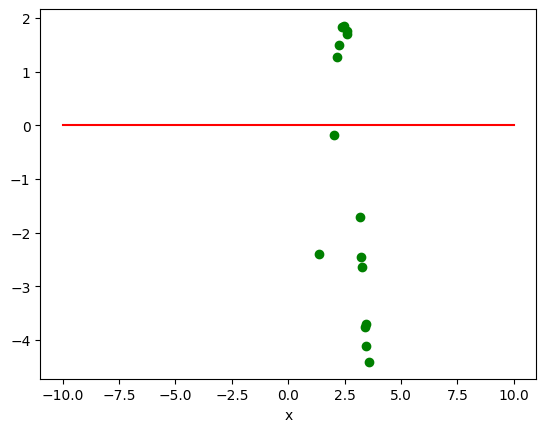

[-1.05929631e-05 -1.05929631e-05 -1.05929631e-05 -1.05929631e-05
 -1.05929631e-05 -1.05929631e-05]
102.29453655703679


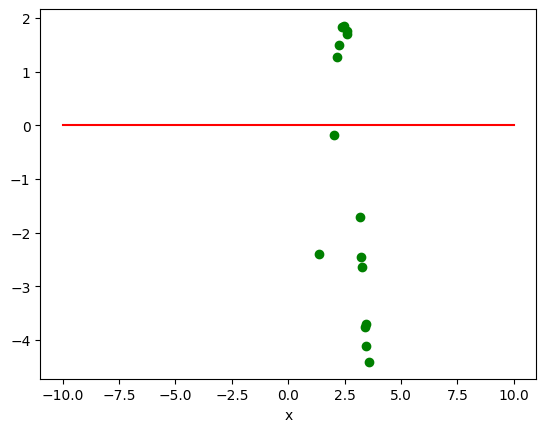

[1.56269043e-10 4.99174159e-10 1.76791407e-09 6.73046313e-09
 2.71403558e-08 1.16486648e-07]
102.58318569284761


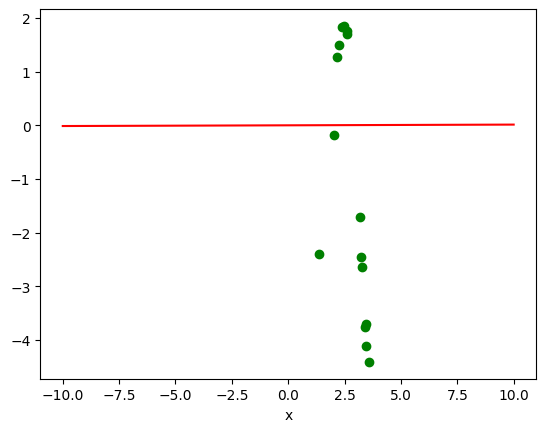

[0.00133417 0.00133432 0.00133503 0.00133838 0.00135415 0.00142773]
144.36486269907314


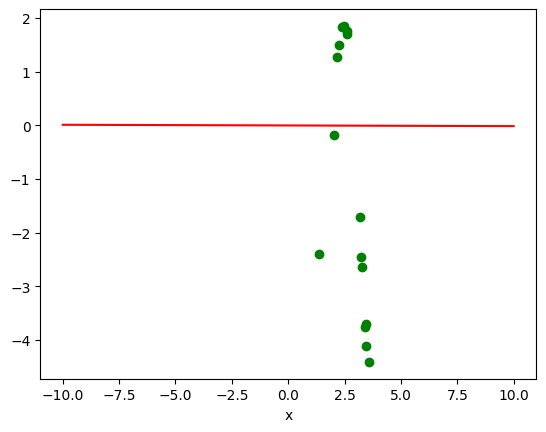

[-0.00127375 -0.00127151 -0.0012561  -0.00115187 -0.00051582  0.00189073]
72.90396437411165


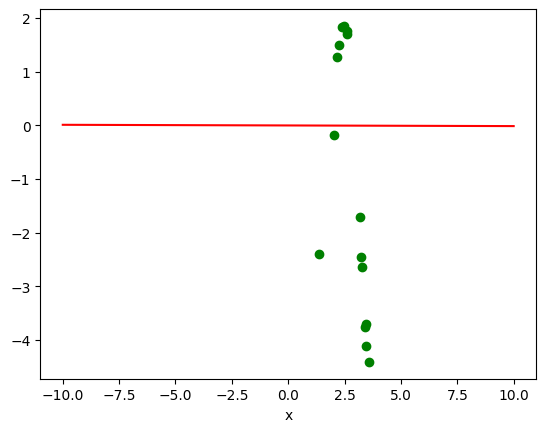

[-0.00121437 -0.00121437 -0.00121437 -0.00121437 -0.00121437 -0.00121437]
73.90763762551956


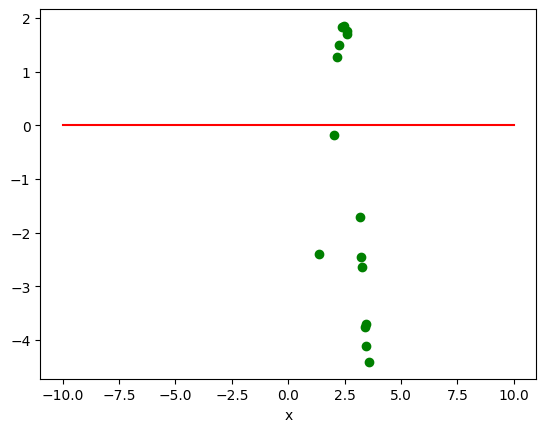

[2.56410256e-08 2.56410256e-08 2.56410256e-08 2.56410256e-08
 2.56410256e-08 2.56410256e-08]
102.5838670464333


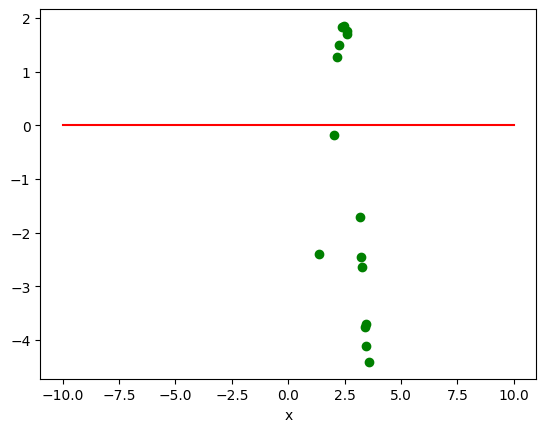

[-1.05929631e-05 -1.05929631e-05 -1.05929631e-05 -1.05929631e-05
 -1.05929631e-05 -1.05929631e-05]
102.29453655703679


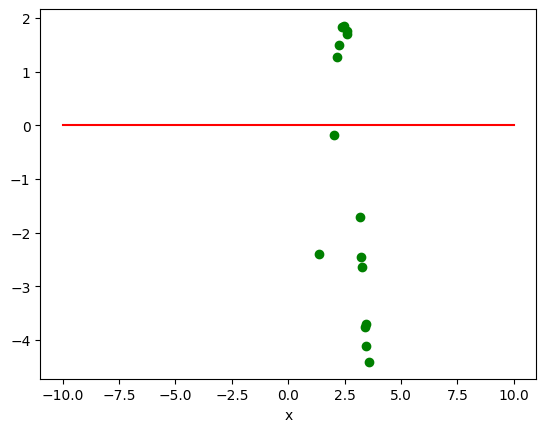

[1.56269043e-10 4.99174159e-10 1.76791407e-09 6.73046313e-09
 2.71403558e-08 1.16486648e-07]
102.58318569284761


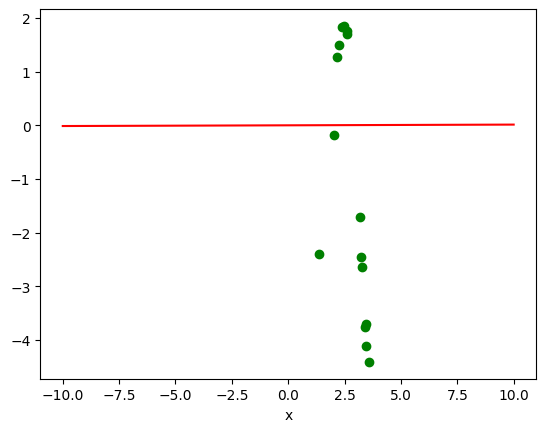

[0.00133417 0.00133432 0.00133503 0.00133838 0.00135415 0.00142773]
144.36486269907314


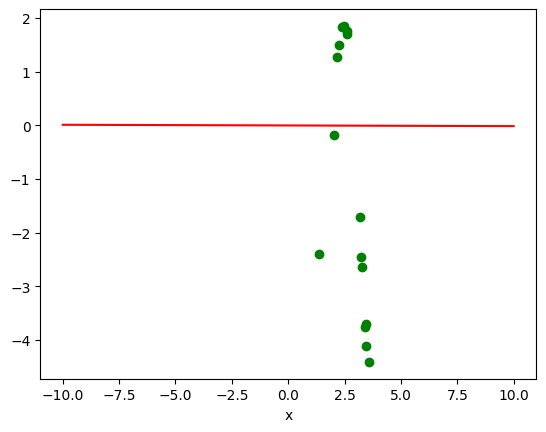

[-0.00127375 -0.00127151 -0.0012561  -0.00115187 -0.00051582  0.00189073]
72.90396437411165


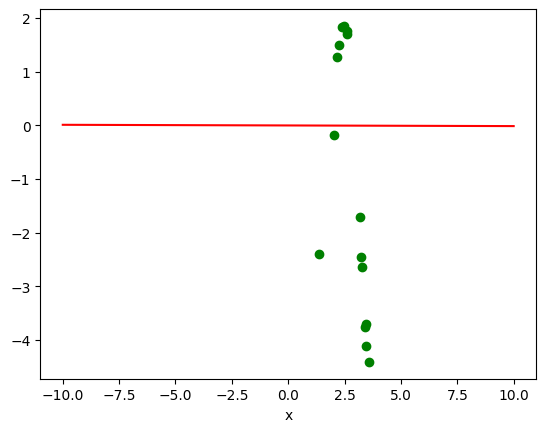

[-0.00121437 -0.00121437 -0.00121437 -0.00121437 -0.00121437 -0.00121437]
73.90763762551956


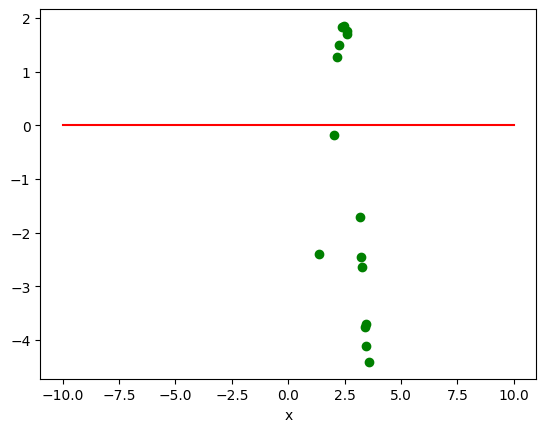

[2.56410256e-08 2.56410256e-08 2.56410256e-08 2.56410256e-08
 2.56410256e-08 2.56410256e-08]
102.5838670464333


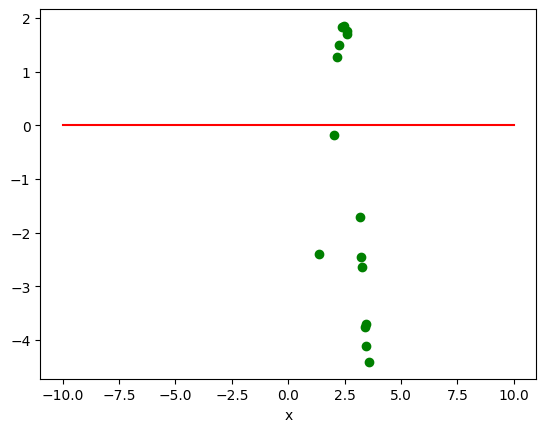

[-1.05929631e-05 -1.05929631e-05 -1.05929631e-05 -1.05929631e-05
 -1.05929631e-05 -1.05929631e-05]
102.29453655703679


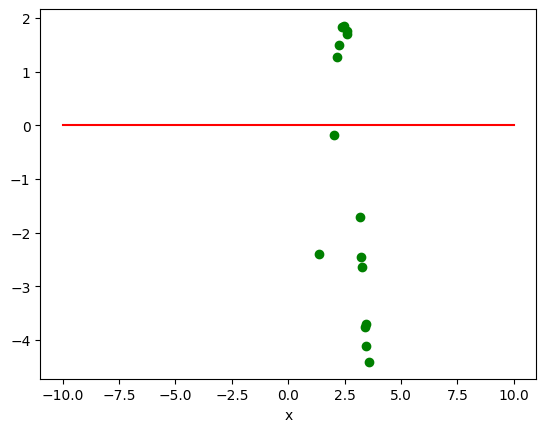

[1.56269043e-10 4.99174159e-10 1.76791407e-09 6.73046313e-09
 2.71403558e-08 1.16486648e-07]
102.58318569284761


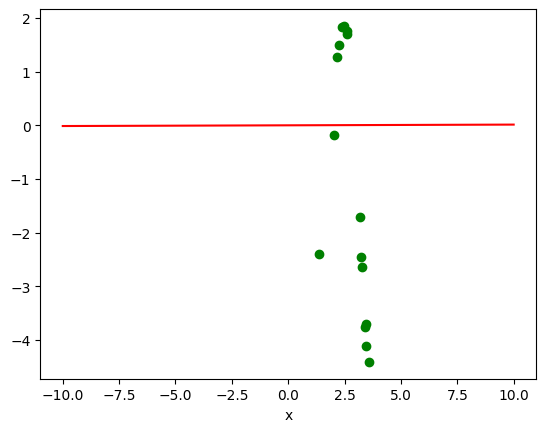

[0.00133417 0.00133432 0.00133503 0.00133838 0.00135415 0.00142773]
144.36486269907314


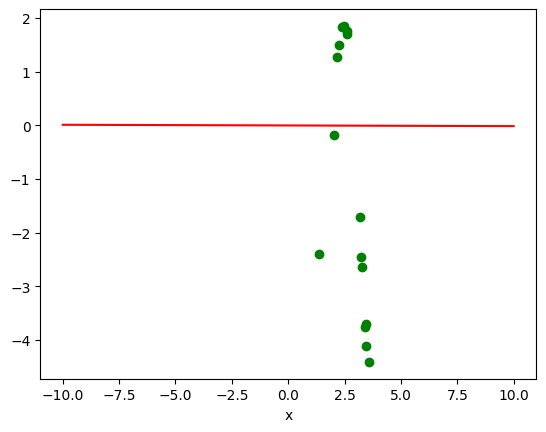

[-0.00127375 -0.00127151 -0.0012561  -0.00115187 -0.00051582  0.00189073]
72.90396437411165


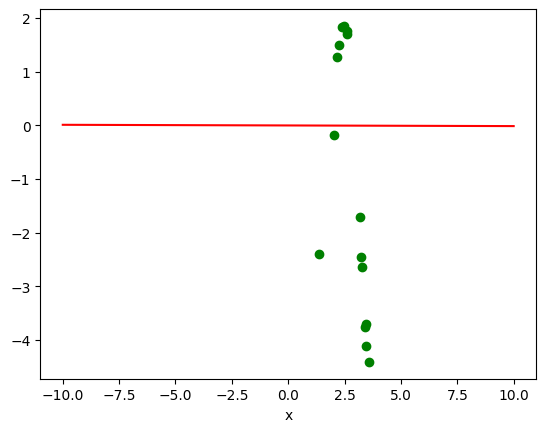

[-0.00121437 -0.00121437 -0.00121437 -0.00121437 -0.00121437 -0.00121437]
73.90763762551956


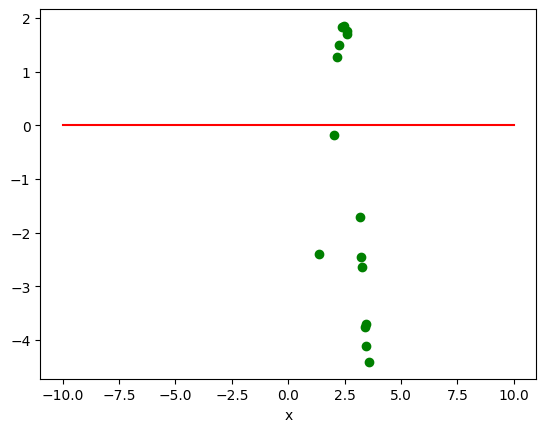

[2.56410256e-08 2.56410256e-08 2.56410256e-08 2.56410256e-08
 2.56410256e-08 2.56410256e-08]
102.5838670464333


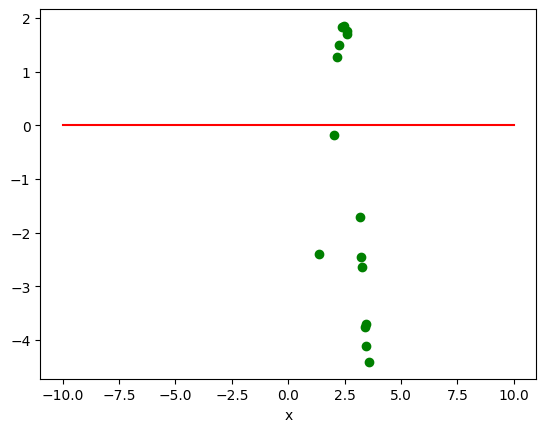

[-1.05929631e-05 -1.05929631e-05 -1.05929631e-05 -1.05929631e-05
 -1.05929631e-05 -1.05929631e-05]
102.29453655703679


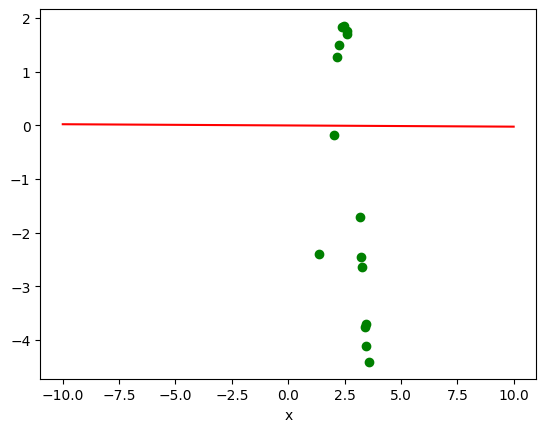

[-0.00225436 -0.00107213  0.00084843  0.00338737  0.00606161  0.00838847]
64.25591902149834


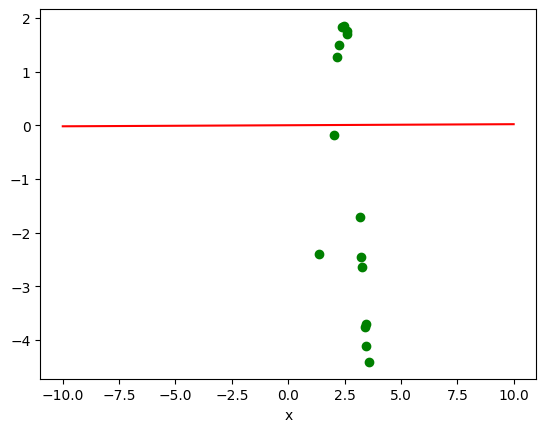

[0.00196117 0.00267473 0.00358871 0.00452375 0.00532037 0.00592347]
179.9242319424229


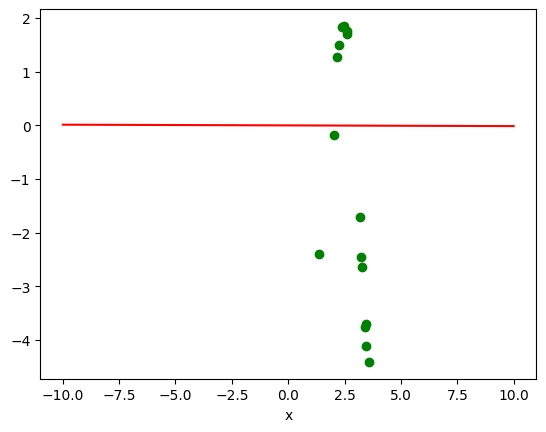

[-0.00134001 -0.00020931  0.00159513  0.00392886  0.00633669  0.00840056]
82.0057356294443


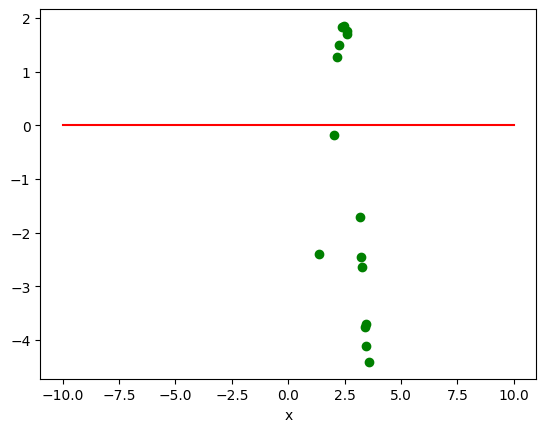

[-4.24298437e-06 -3.08175016e-06 -2.13535667e-06 -1.43682112e-06
 -9.47445593e-07 -6.13164254e-07]
102.47882689849612


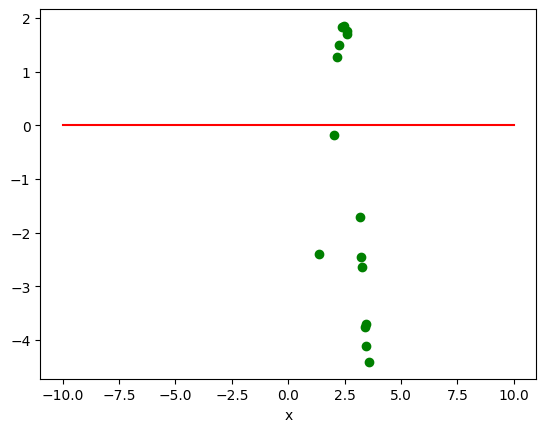

[3.62528196e-08 3.62528196e-08 3.62528196e-08 3.62528196e-08
 3.62528196e-08 3.62528196e-08]
102.58415653187177


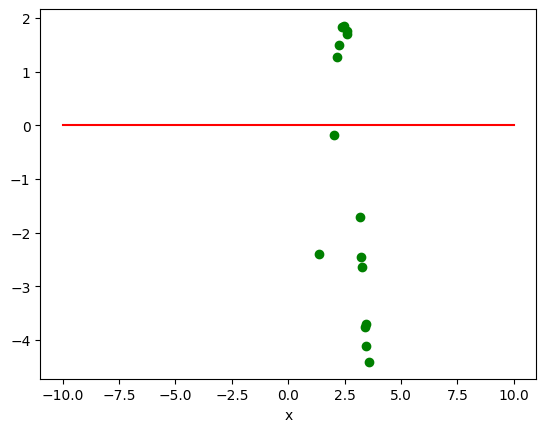

[-3.81438865e-06 -2.76966603e-06 -1.91814689e-06 -1.28958927e-06
 -8.49208071e-07 -5.48374555e-07]
102.48937065659342


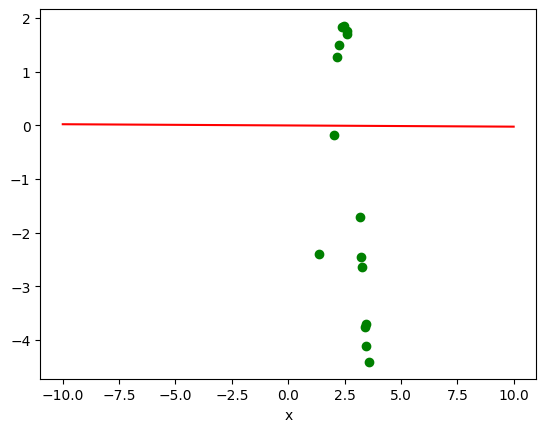

[-0.00225436 -0.00107213  0.00084843  0.00338737  0.00606161  0.00838847]
64.25591902149834


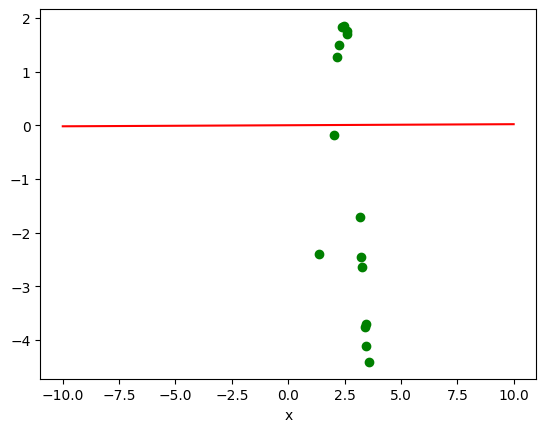

[0.00196117 0.00267473 0.00358871 0.00452375 0.00532037 0.00592347]
179.9242319424229


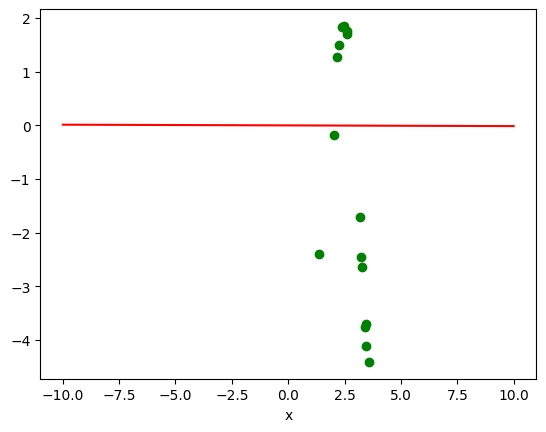

[-0.00134001 -0.00020931  0.00159513  0.00392886  0.00633669  0.00840056]
82.0057356294443


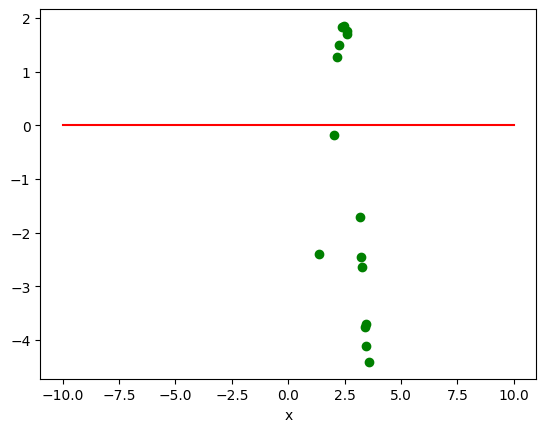

[-4.24298437e-06 -3.08175016e-06 -2.13535667e-06 -1.43682112e-06
 -9.47445593e-07 -6.13164254e-07]
102.47882689849612


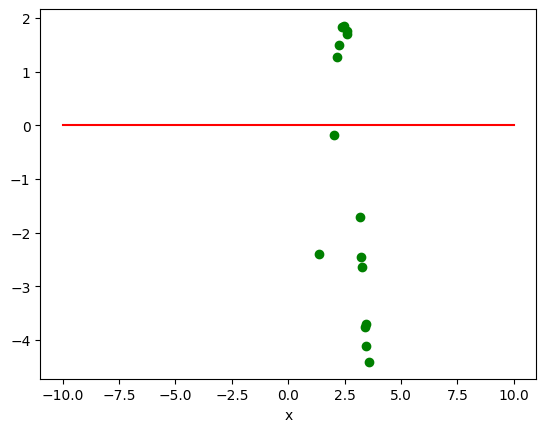

[3.62528196e-08 3.62528196e-08 3.62528196e-08 3.62528196e-08
 3.62528196e-08 3.62528196e-08]
102.58415653187177


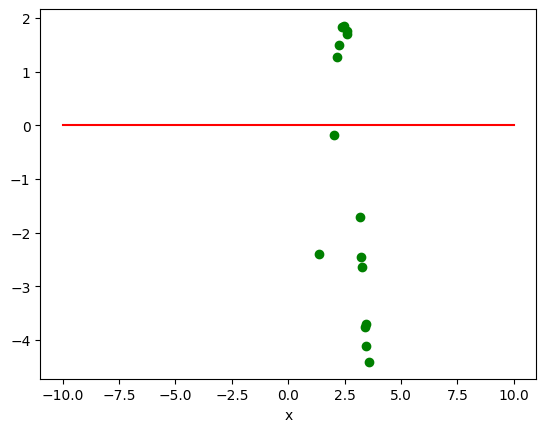

[-3.81438865e-06 -2.76966603e-06 -1.91814689e-06 -1.28958927e-06
 -8.49208071e-07 -5.48374555e-07]
102.48937065659342


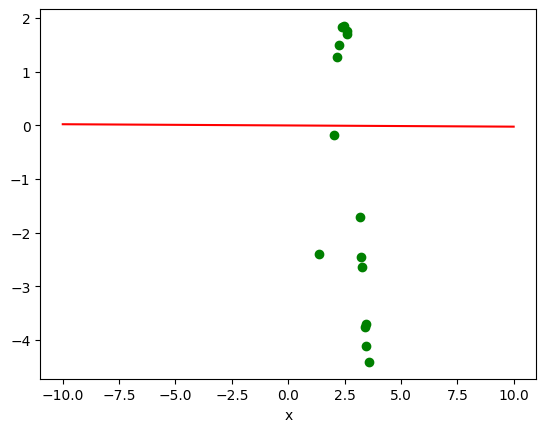

[-0.00225436 -0.00107213  0.00084843  0.00338737  0.00606161  0.00838847]
64.25591902149834


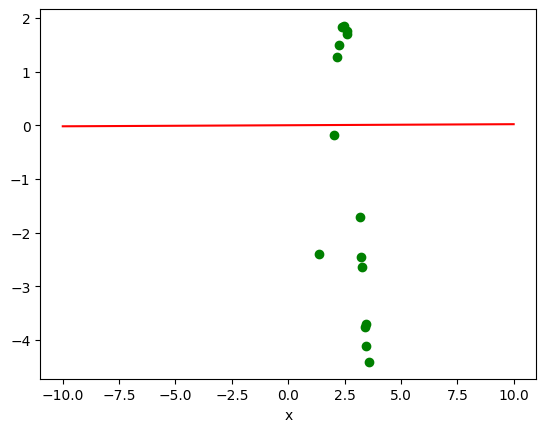

[0.00196117 0.00267473 0.00358871 0.00452375 0.00532037 0.00592347]
179.9242319424229


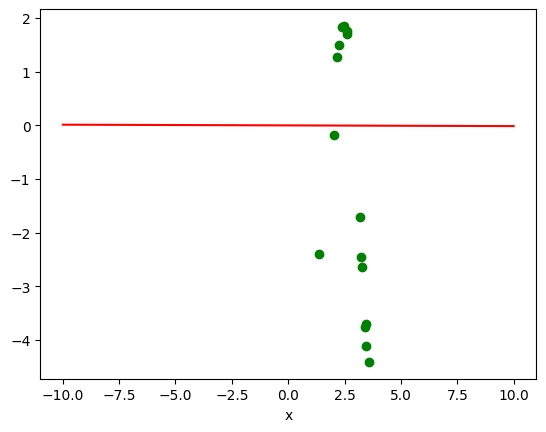

[-0.00134001 -0.00020931  0.00159513  0.00392886  0.00633669  0.00840056]
82.0057356294443


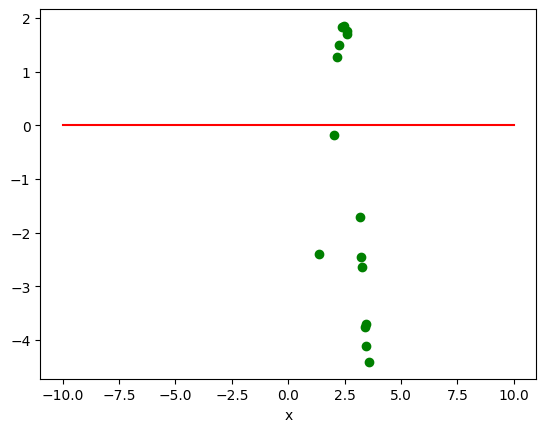

[-4.24298437e-06 -3.08175016e-06 -2.13535667e-06 -1.43682112e-06
 -9.47445593e-07 -6.13164254e-07]
102.47882689849612


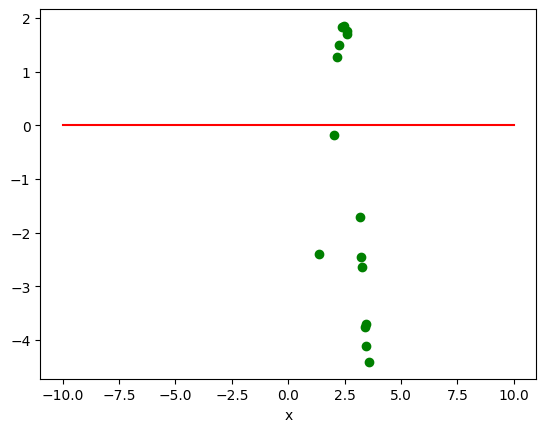

[3.62528196e-08 3.62528196e-08 3.62528196e-08 3.62528196e-08
 3.62528196e-08 3.62528196e-08]
102.58415653187177


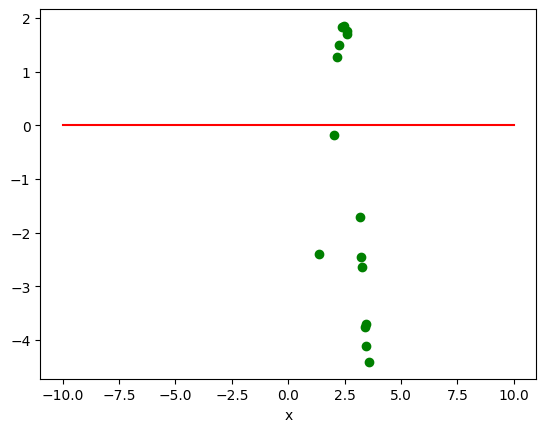

[-3.81438865e-06 -2.76966603e-06 -1.91814689e-06 -1.28958927e-06
 -8.49208071e-07 -5.48374555e-07]
102.48937065659342


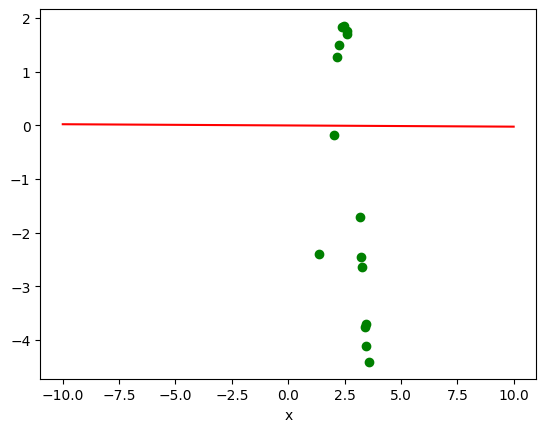

[-0.00225436 -0.00107213  0.00084843  0.00338737  0.00606161  0.00838847]
64.25591902149834


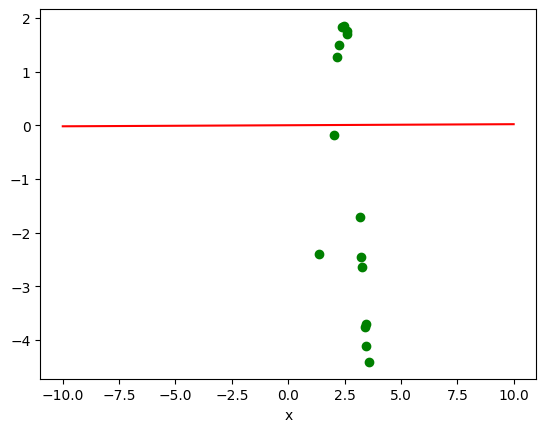

[0.00196117 0.00267473 0.00358871 0.00452375 0.00532037 0.00592347]
179.9242319424229


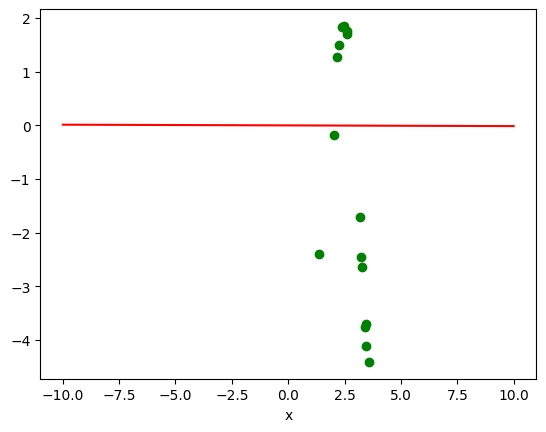

[-0.00134001 -0.00020931  0.00159513  0.00392886  0.00633669  0.00840056]
82.0057356294443


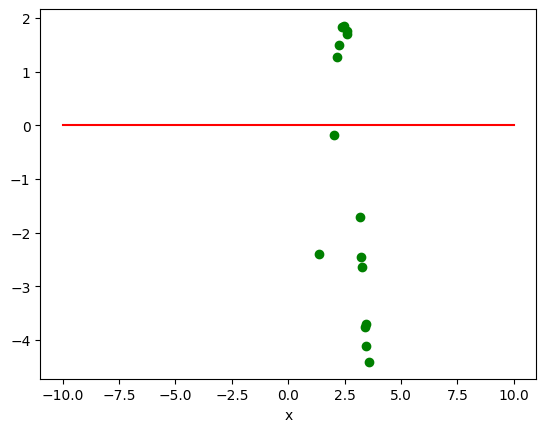

[-4.24298437e-06 -3.08175016e-06 -2.13535667e-06 -1.43682112e-06
 -9.47445593e-07 -6.13164254e-07]
102.47882689849612


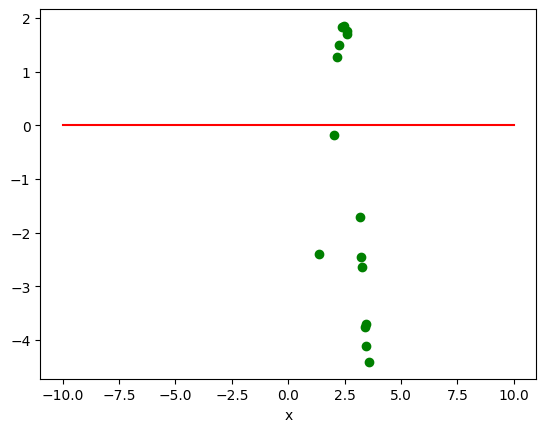

[3.62528196e-08 3.62528196e-08 3.62528196e-08 3.62528196e-08
 3.62528196e-08 3.62528196e-08]
102.58415653187177


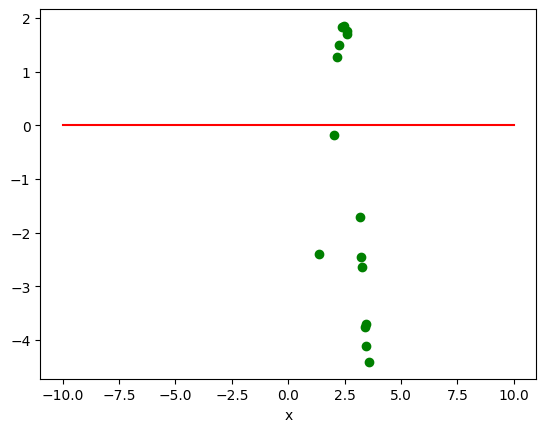

[-3.81438865e-06 -2.76966603e-06 -1.91814689e-06 -1.28958927e-06
 -8.49208071e-07 -5.48374555e-07]
102.48937065659342


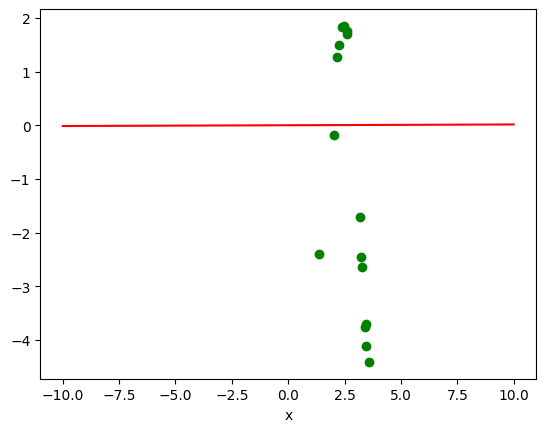

[0.00145457 0.00260546 0.00398921 0.00534411 0.00646311 0.00729148]
166.62501761382913


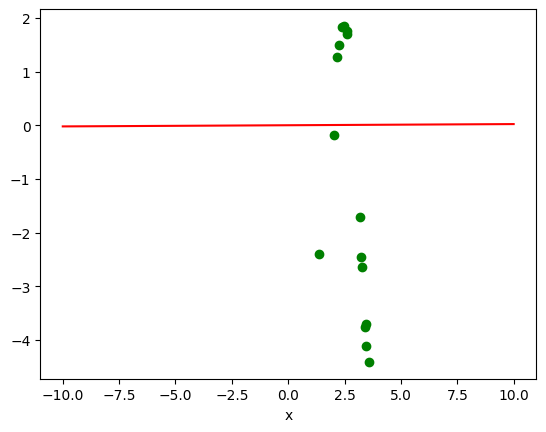

[0.00217009 0.00262132 0.00307375 0.00345394 0.00373822 0.00393775]
183.22545399427915


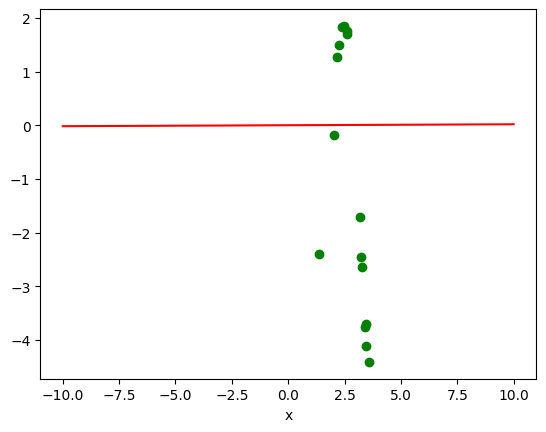

[0.0017882  0.00283888 0.0040823  0.00528167 0.00626173 0.00698287]
178.18894549672694


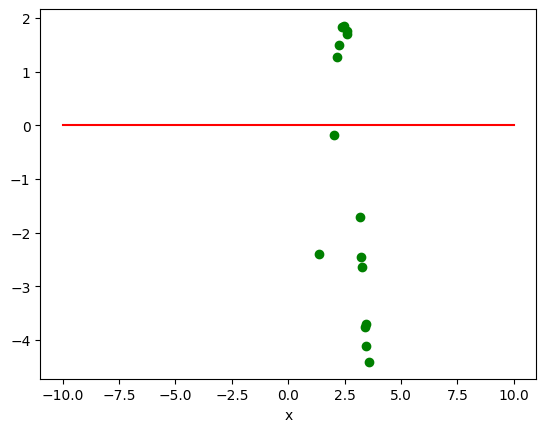

[-1.18278662e-06 -6.52852847e-07 -2.34588069e-07  6.73487959e-08
  2.75690954e-07  4.16553756e-07]
102.55604893578327


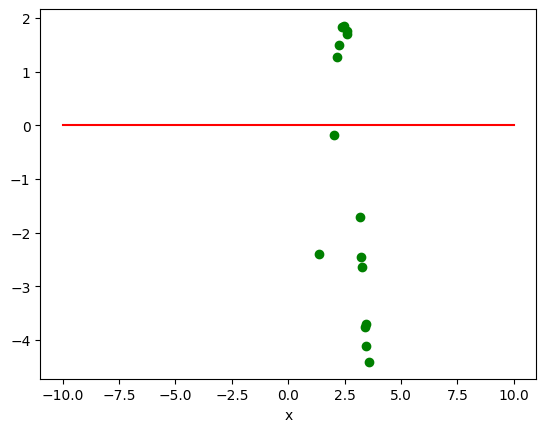

[1.90804314e-08 1.90804314e-08 1.90804314e-08 1.90804314e-08
 1.90804314e-08 1.90804313e-08]
102.58368807642078


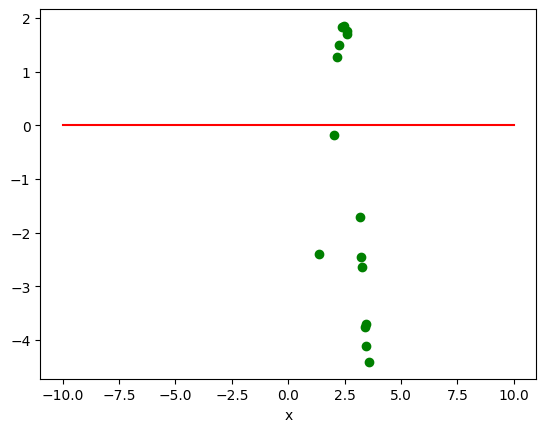

[3.53464991e-08 3.53464991e-08 3.53464991e-08 3.53464991e-08
 3.53464991e-08 3.53464991e-08]
102.58413180778959


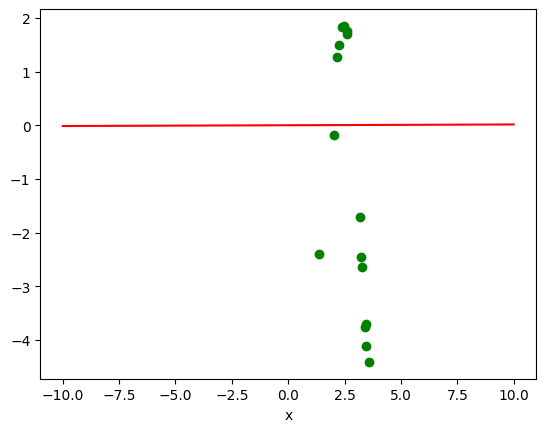

[0.00145457 0.00260546 0.00398921 0.00534411 0.00646311 0.00729148]
166.62501761382913


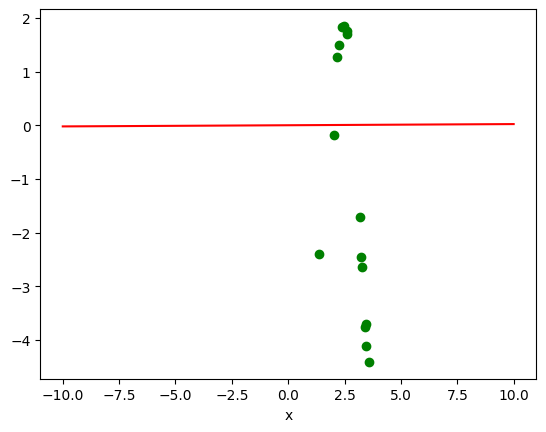

[0.00217009 0.00262132 0.00307375 0.00345394 0.00373822 0.00393775]
183.22545399427915


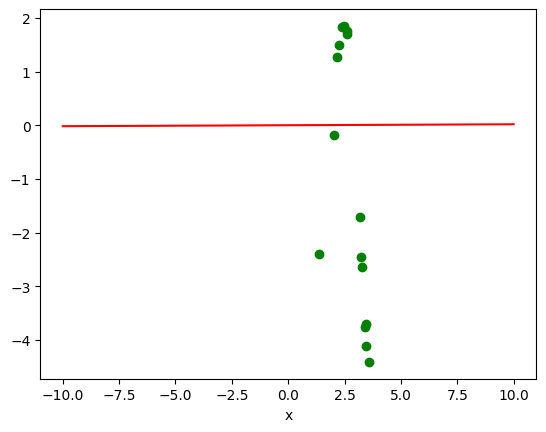

[0.0017882  0.00283888 0.0040823  0.00528167 0.00626173 0.00698287]
178.18894549672694


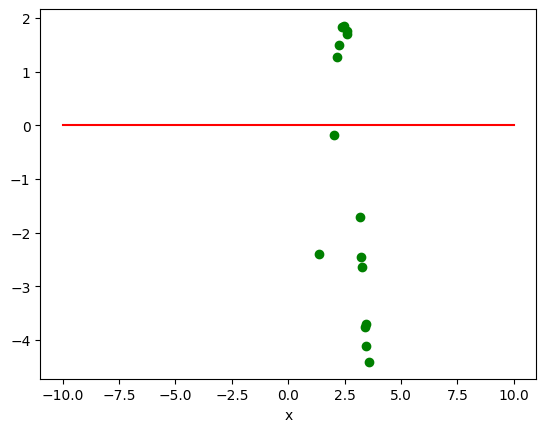

[-1.18278662e-06 -6.52852847e-07 -2.34588069e-07  6.73487959e-08
  2.75690954e-07  4.16553756e-07]
102.55604893578327


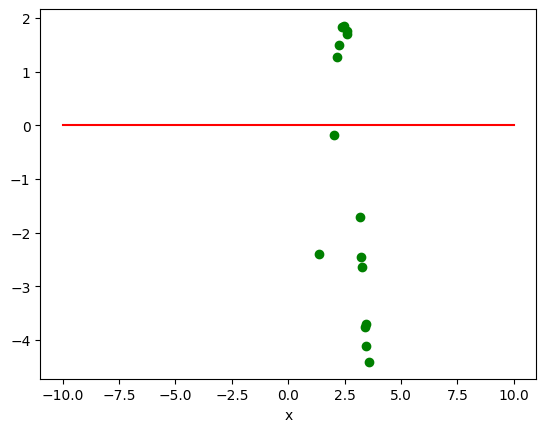

[1.90804314e-08 1.90804314e-08 1.90804314e-08 1.90804314e-08
 1.90804314e-08 1.90804313e-08]
102.58368807642078


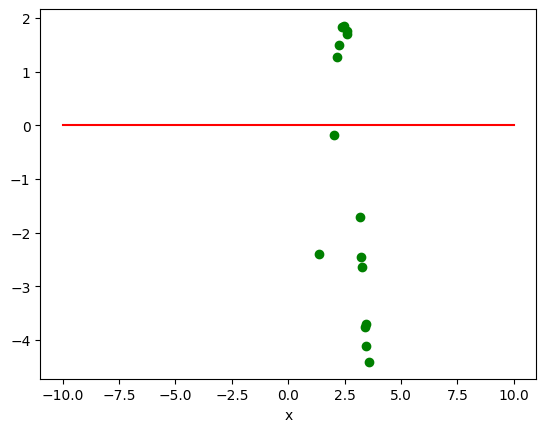

[3.53464991e-08 3.53464991e-08 3.53464991e-08 3.53464991e-08
 3.53464991e-08 3.53464991e-08]
102.58413180778959


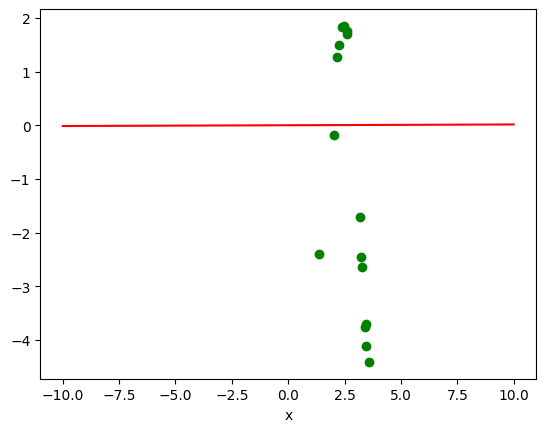

[0.00145457 0.00260546 0.00398921 0.00534411 0.00646311 0.00729148]
166.62501761382913


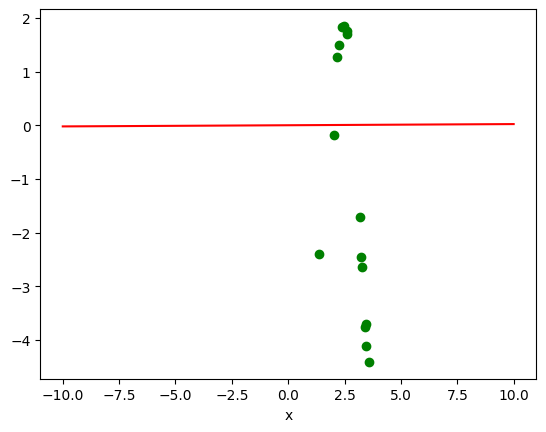

[0.00217009 0.00262132 0.00307375 0.00345394 0.00373822 0.00393775]
183.22545399427915


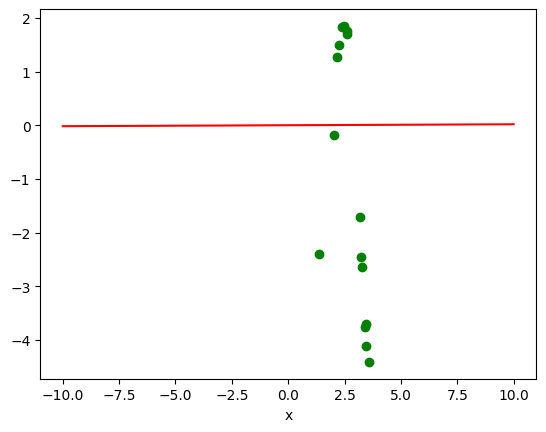

[0.0017882  0.00283888 0.0040823  0.00528167 0.00626173 0.00698287]
178.18894549672694


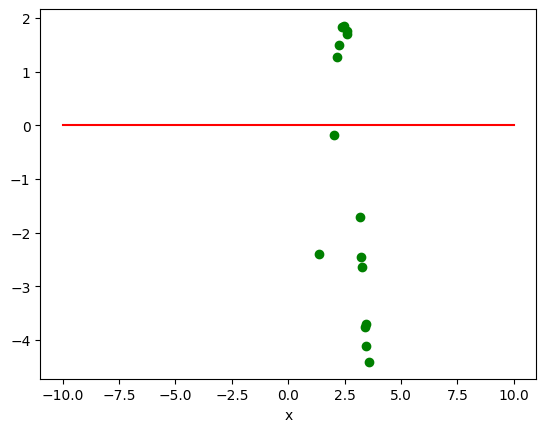

[-1.18278662e-06 -6.52852847e-07 -2.34588069e-07  6.73487959e-08
  2.75690954e-07  4.16553756e-07]
102.55604893578327


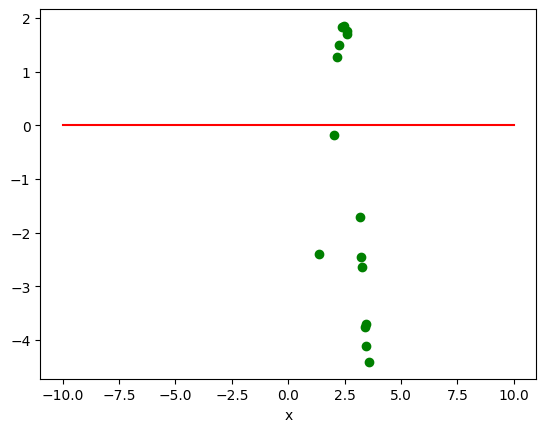

[1.90804314e-08 1.90804314e-08 1.90804314e-08 1.90804314e-08
 1.90804314e-08 1.90804313e-08]
102.58368807642078


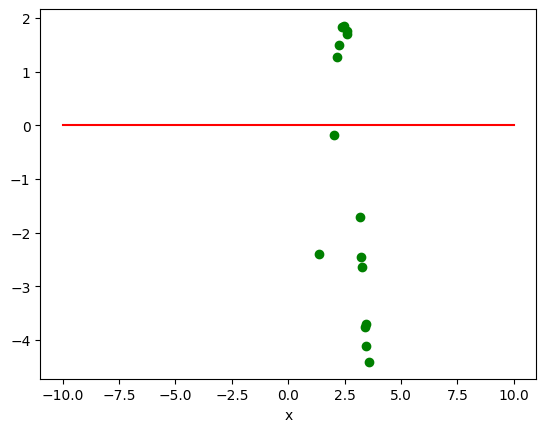

[3.53464991e-08 3.53464991e-08 3.53464991e-08 3.53464991e-08
 3.53464991e-08 3.53464991e-08]
102.58413180778959


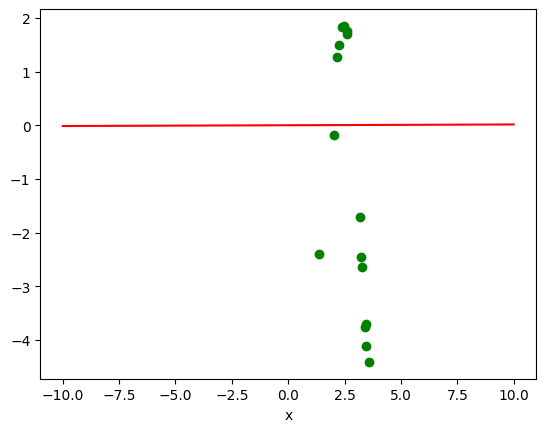

[0.00145457 0.00260546 0.00398921 0.00534411 0.00646311 0.00729148]
166.62501761382913


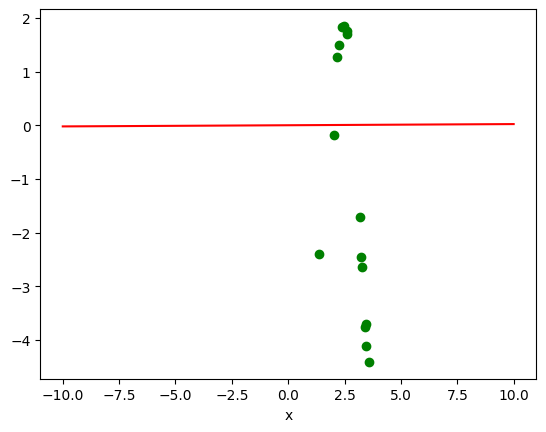

[0.00217009 0.00262132 0.00307375 0.00345394 0.00373822 0.00393775]
183.22545399427915


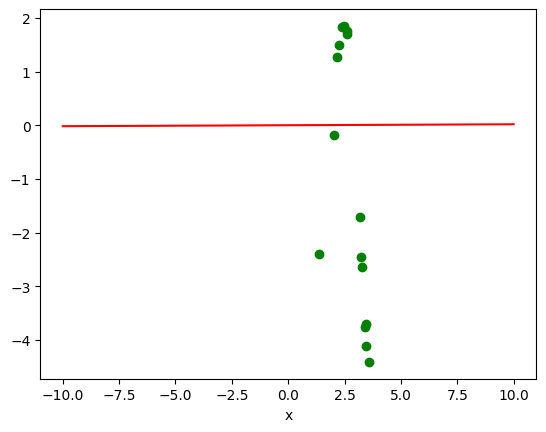

[0.0017882  0.00283888 0.0040823  0.00528167 0.00626173 0.00698287]
178.18894549672694


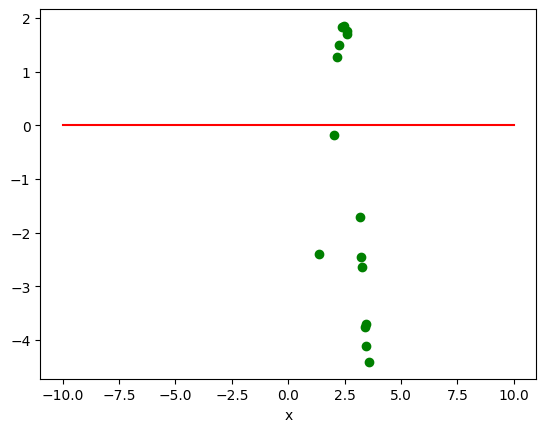

[-1.18278662e-06 -6.52852847e-07 -2.34588069e-07  6.73487959e-08
  2.75690954e-07  4.16553756e-07]
102.55604893578327


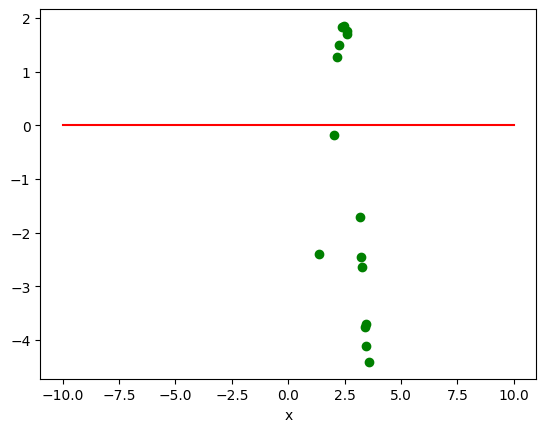

[1.90804314e-08 1.90804314e-08 1.90804314e-08 1.90804314e-08
 1.90804314e-08 1.90804313e-08]
102.58368807642078


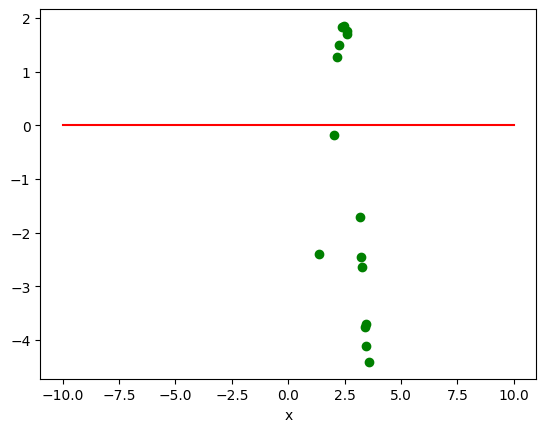

[3.53464991e-08 3.53464991e-08 3.53464991e-08 3.53464991e-08
 3.53464991e-08 3.53464991e-08]
102.58413180778959


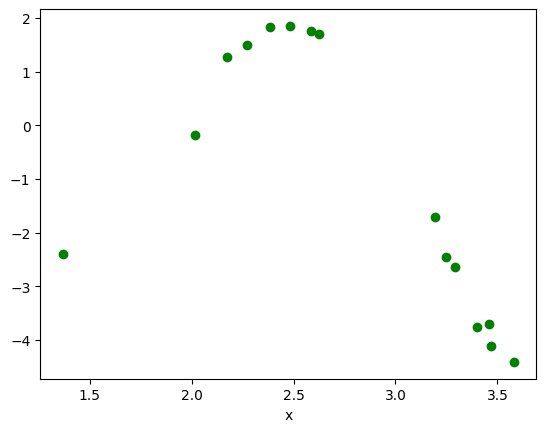

[nan nan nan nan nan nan]
nan


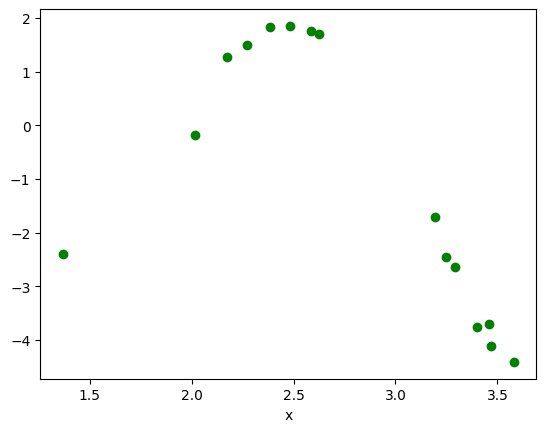

[nan nan nan nan nan nan]
nan


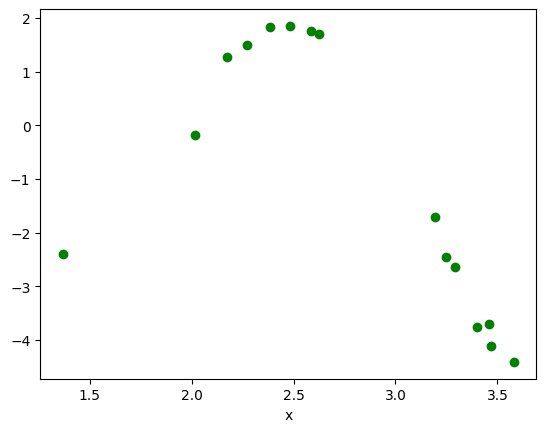

[nan nan nan nan nan nan]
nan


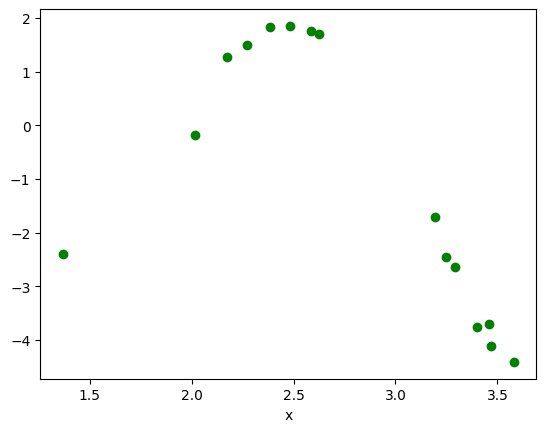

[nan nan nan nan nan nan]
nan


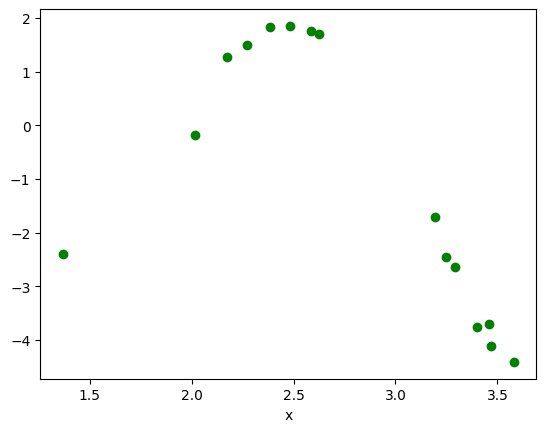

[nan nan nan nan nan nan]
nan


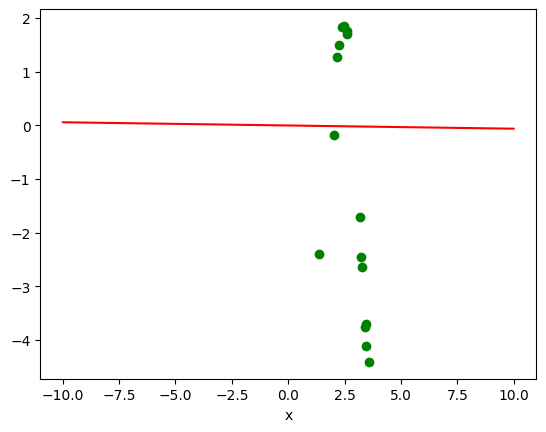

[-5.98898851e-03 -1.74684290e-03 -5.04857027e-04 -1.43582898e-04
 -3.96928608e-05 -1.04110337e-05]
38.631250908395806


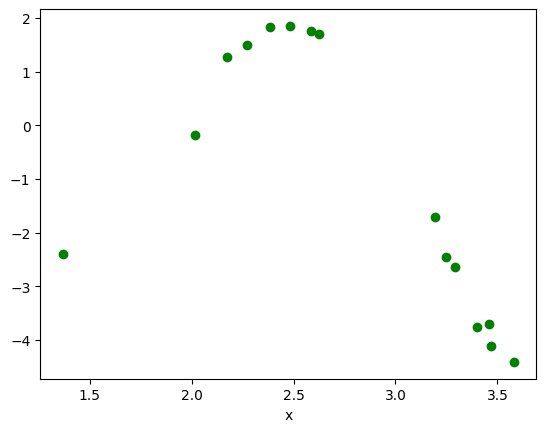

[nan nan nan nan nan nan]
nan


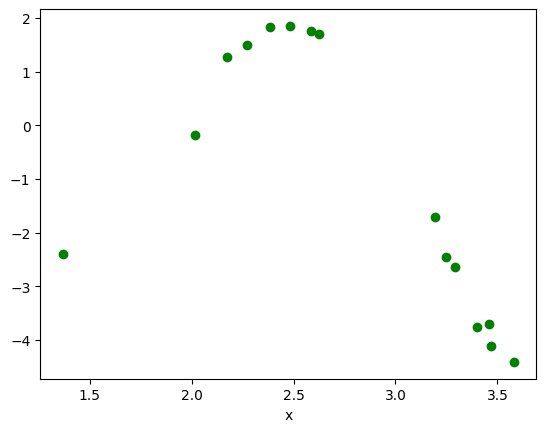

[nan nan nan nan nan nan]
nan


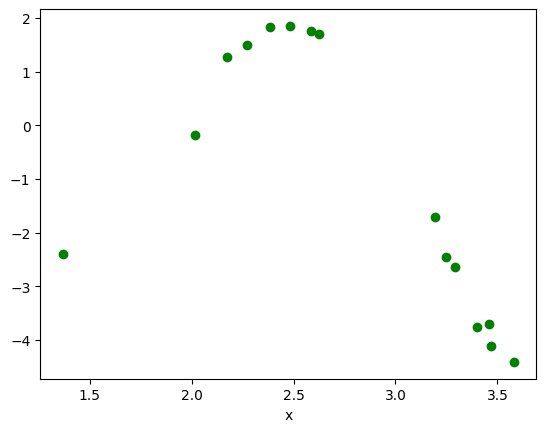

[nan nan nan nan nan nan]
nan


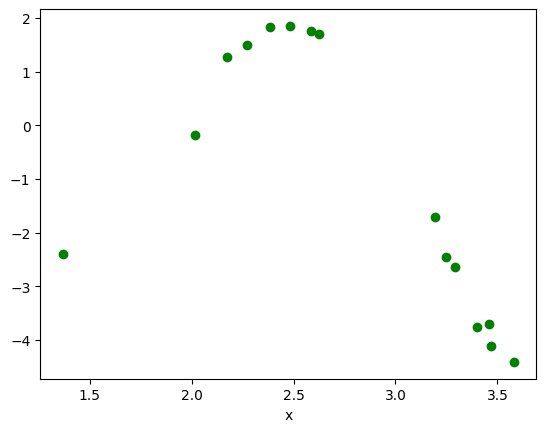

[nan nan nan nan nan nan]
nan


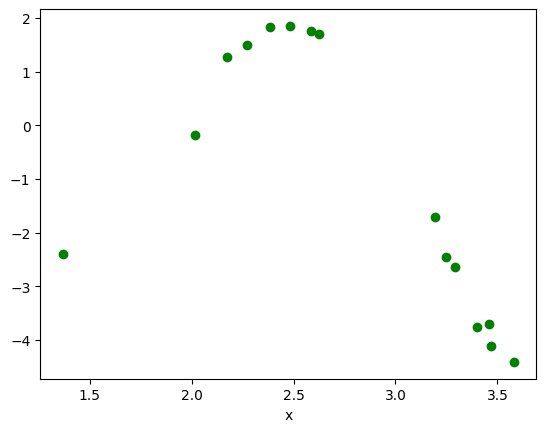

[nan nan nan nan nan nan]
nan


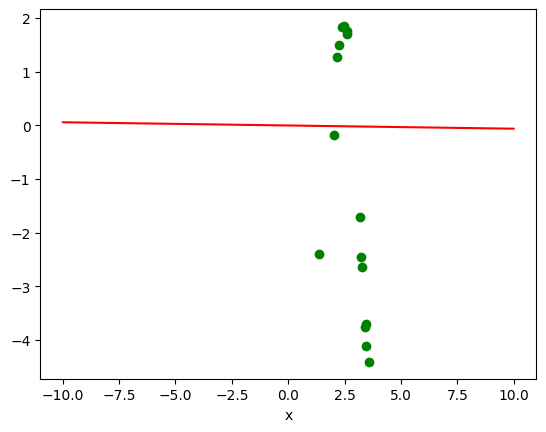

[-5.98898851e-03 -1.74684290e-03 -5.04857027e-04 -1.43582898e-04
 -3.96928608e-05 -1.04110337e-05]
38.631250908395806


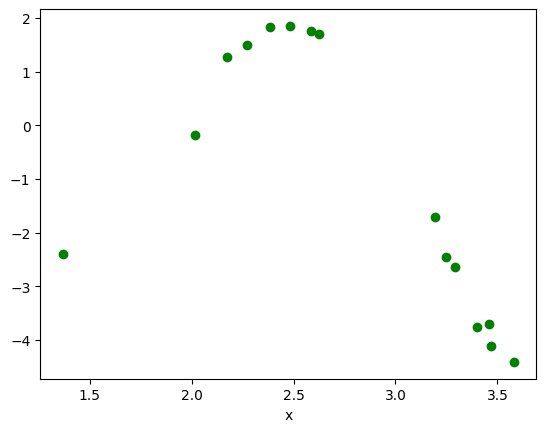

[nan nan nan nan nan nan]
nan


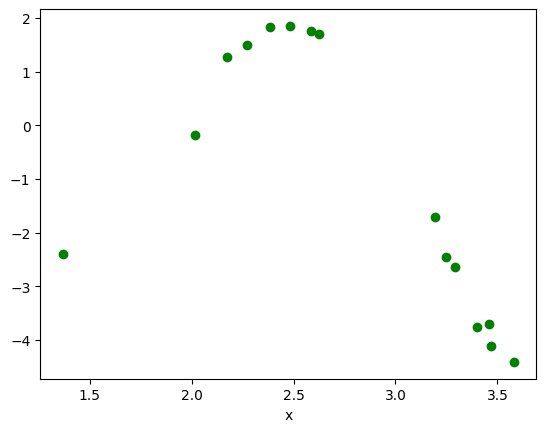

[nan nan nan nan nan nan]
nan


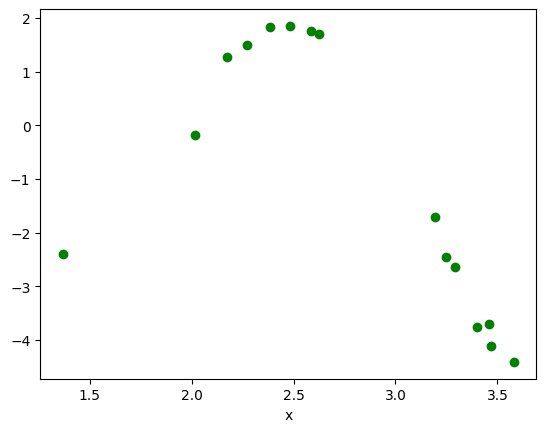

[nan nan nan nan nan nan]
nan


In [ ]:
import time
import tracemalloc


def calc_y(x, coeffs):
    return sum([coeffs[i] * (x ** i) for i in range(len(coeffs))])


def generate_data(coeffs, num_of_points, x_range_left, x_range_right, deviation):
    X = [random.uniform(x_range_left, x_range_right) for i in range(num_of_points)]
    Y = [calc_y(X[i], coeffs) + random.uniform(-deviation, +deviation) for i in range(num_of_points)]

    return [np.array(X), np.array(Y)]


def gen_linear_reg(coeffs, num_of_points, x_range_left, x_range_right, deviation, calculated_lambdas):
    T = np.array(calculated_lambdas)
    points = generate_data(coeffs, num_of_points, x_range_left, x_range_right, deviation)
    X, Y = points
    W = np.zeros(len(coeffs))
    return LinearRegression(T, W, X, Y)


def test_universal(lin_reg, lr, method, lrs):
    # 1 - mem, 2 - steps, 3 - time, 4 - sqrs
    res_univ = []

    start = time.time()
    tracemalloc.start()
    steps = sgd_handler(lin_reg, cur_lr, method, lrs=lrs)
    res_univ.append(tracemalloc.get_traced_memory())
    tracemalloc.stop()
    end = time.time()

    res_univ.append(steps)
    res_univ.append(end - start)
    res_univ.append(lin_reg.loss(lin_reg.W) / len(lin_reg.X))

    return res_univ


power_lambda = lambda power: lambda x: x ** power

first_tests_val = gen_linear_reg(
    coeffs=[24., -26., -15., 25., -9., 1.],
    num_of_points=15,
    x_range_left=1.,
    x_range_right=4.,
    deviation=0.3,
    calculated_lambdas=[power_lambda(5 - i) for i in range(6)]
)

start_w_for_first = np.array([0., 0., 0., 0., 0., 0.])
start_coeffs_for_first = [1., -9., 25., -15., -26., 24.]

test_results = {}

for method in Methods:
    for regularization in Regularization:
        for lr in LearningRate:
            for lrs in LearningRateScheduling:
                cur_lr = None
                if lr == LearningRate.Const:
                    cur_lr = lambda x: 0.01
                elif lr == LearningRate.Dichotomy:
                    cur_lr = lr_dichotomy(0.001, 0.0001)

                first_tests_val.W = np.zeros(len(first_tests_val.W))
                results = test_universal(first_tests_val, cur_lr, method, lrs)
                visualise_points(first_tests_val)
                test_results[method.name, regularization.name, lr.name, lrs.name] = results

for key in test_results:
    print(str(key) + " -> ")
    print('\n'.join(str(val) for val in test_results[key]))
    print()